# Crash Course in Causality: Does Gender Cause Different Survival Rates on the Titanic?

## Hu Liu - NEU - INFO7390 - 2025 Spring

# Abstract
This notebook explores the causal relationship between passenger characteristics and survival rates on the Titanic, with a primary focus on gender as a potential causal factor. We investigate the question: "Does being female cause a higher chance of survival on the Titanic?" Through data preparation techniques essential for causal inference, we demonstrate how to handle missing values, encode categorical variables, and control for confounding factors. This analysis serves as an introduction to causal inference methods in a real-world historical dataset, illustrating how proper data preparation can lead to more reliable causal conclusions in machine learning applications.

# Development Theory

## Theory: Causality and Data Preparation

### 1. Introduction to Causality

Causality refers to the relationship between causes and effects - where one event (the cause) makes another event (the effect) occur. Unlike correlation which only describes association between variables, causality implies a directional relationship: changes in X cause changes in Y.


Key causality concepts include:
- **Confounding variables**: Variables that influence both the cause and effect
- **Colliders**: Variables affected by both the cause and the effect
- **Mediators**: Variables in the causal pathway between cause and effect
- **Direct vs. Indirect effects**: Effects that occur with or without intermediate variables

### 2. Causal Graphs and DAGs

Directed Acyclic Graphs (DAGs) are mathematical tools used to visually represent causal relationships. In a DAG:
- Nodes represent variables
- Directed edges (arrows) represent causal effects
- The absence of edges represents the absence of direct causal effects

![Directed Acyclic Graph](https://upload.wikimedia.org/wikipedia/commons/2/21/Graph_Condensation.svg)

### 3. Data Preparation for Causal Inference

Proper data preparation is crucial for valid causal inference. Key steps include:


#### 3.1 Handling Missing Data

Missing data can lead to biased causal estimates if the missingness is related to the outcome. Approaches include:
- Complete case analysis (dropping missing values)
- Imputation methods (mean, median, mode, model-based)
- Multiple imputation for uncertainty quantification

#### 3.2 Feature Engineering and Selection

For causal inference, feature selection differs from predictive modeling:
- **Include confounders**: Variables affecting both treatment and outcome
- **Exclude colliders**: Variables affected by both treatment and outcome
- **Caution with mediators**: Including mediators blocks indirect effects

#### 3.3 Encoding Categorical Variables

Categorical variables require special handling for causal inference:
- One-hot encoding for nominal variables
- Effect coding for balanced comparisons
- Ordinal encoding when order matters

### 4. Methods for Causal Effect Estimation

Common methods to estimate causal effects from observational data include:

#### 4.1 Matching

Matching methods aim to create comparable groups by pairing treated units with similar control units:
- Exact matching
- Propensity score matching
- Coarsened exact matching

#### 4.2 Stratification and Weighting

These methods adjust for confounding by:
- Stratifying data into homogeneous subgroups
- Weighting observations (e.g., inverse probability weighting)

#### 4.3 Regression-Based Methods

Regression can estimate causal effects by:
- Controlling for confounders as covariates
- Interaction terms for heterogeneous effects
- Double robust methods combining regression and weighting

<>:228: SyntaxWarning: invalid escape sequence '\.'
<>:228: SyntaxWarning: invalid escape sequence '\.'
/var/folders/p_/2v9fcmhd1ms0468hpxd9nlx40000gn/T/ipykernel_22844/280295255.py:228: SyntaxWarning: invalid escape sequence '\.'
  causal_data['Title'] = causal_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


Training dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Descriptive statistics of the training dataset:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000  

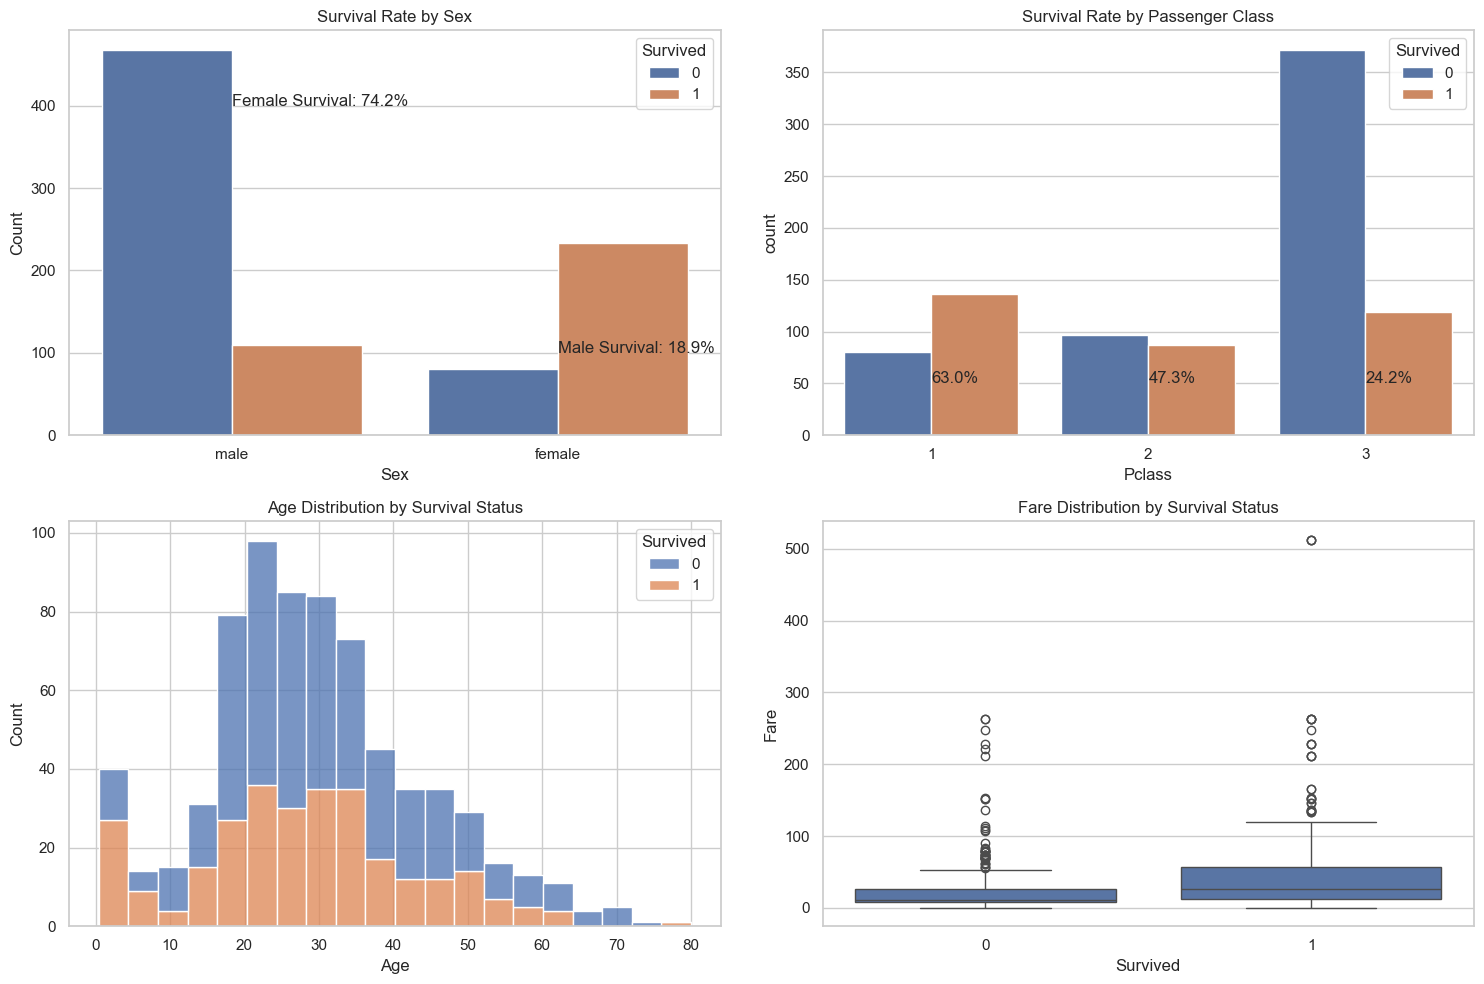

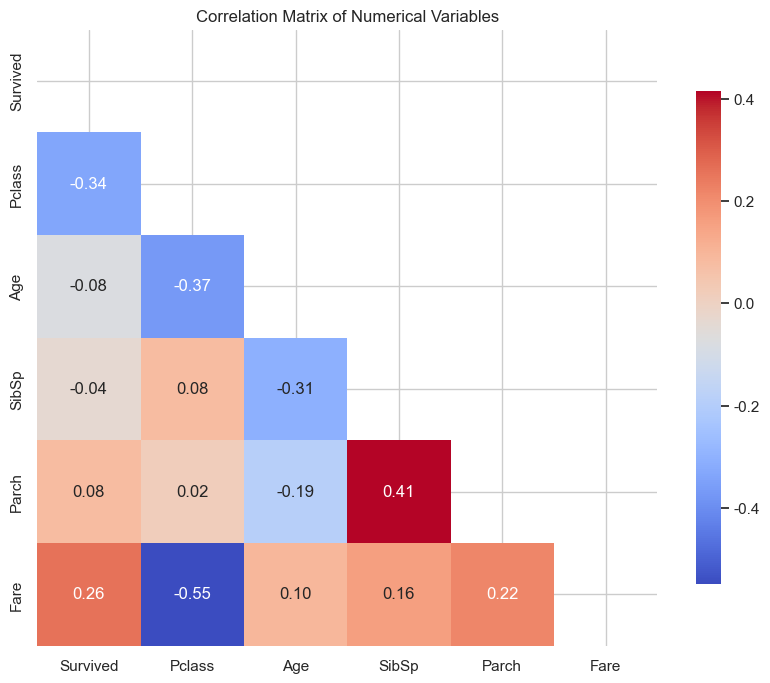


Naive correlation between being female and survival: 0.5434
Survival rate for females: 0.7420
Survival rate for males: 0.1889
Difference in survival rates: 0.5531

===== Analysis of Missing Data Structure =====

Relationship between missing age and other variables:

Pclass distribution with known age:
Pclass
3    0.497199
1    0.260504
2    0.242297
Name: proportion, dtype: float64

Pclass distribution with missing age:
Pclass
3    0.768362
1    0.169492
2    0.062147
Name: proportion, dtype: float64

Sex distribution with known age:
Sex
male      0.634454
female    0.365546
Name: proportion, dtype: float64

Sex distribution with missing age:
Sex
male      0.700565
female    0.299435
Name: proportion, dtype: float64

Survived distribution with known age:
Survived
0    0.593838
1    0.406162
Name: proportion, dtype: float64

Survived distribution with missing age:
Survived
0    0.706215
1    0.293785
Name: proportion, dtype: float64
Average Fare with known age: 34.694514005602244
Avera

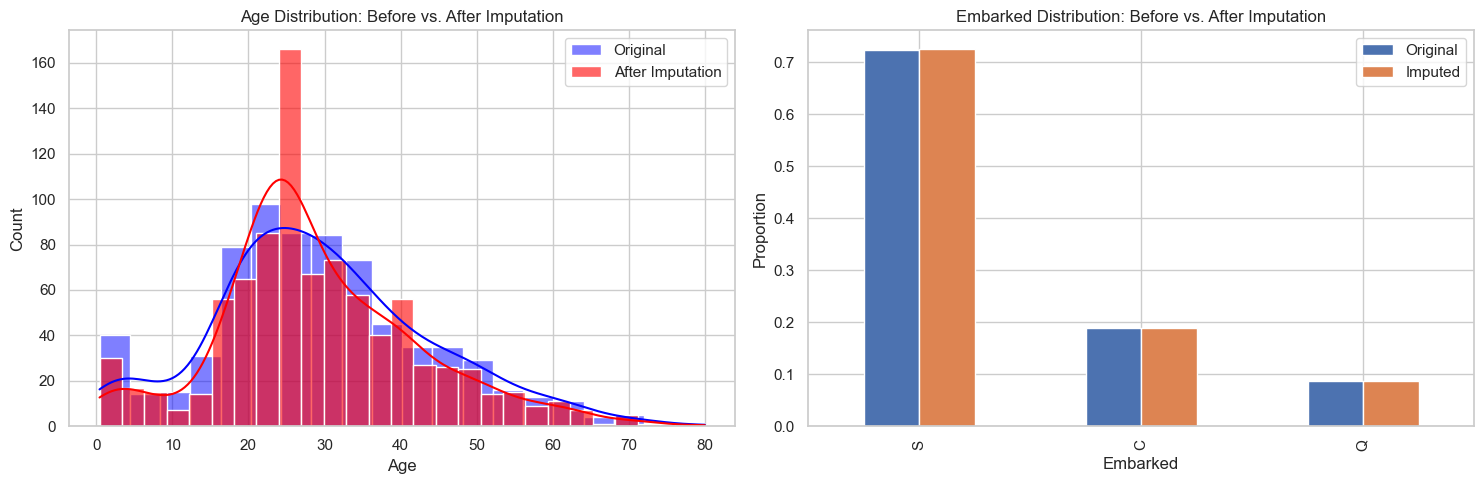


===== Variables by Type for Causal Analysis =====
Treatment variable: Female (1 = Female, 0 = Male)
Outcome variable: Survived (1 = Survived, 0 = Did not survive)
Potential confounders: Pclass, Age, Fare, Embarked, Title
Potential mediators: (Variables through which gender affects survival)
Potential instrumental variables: (None obvious in this dataset)


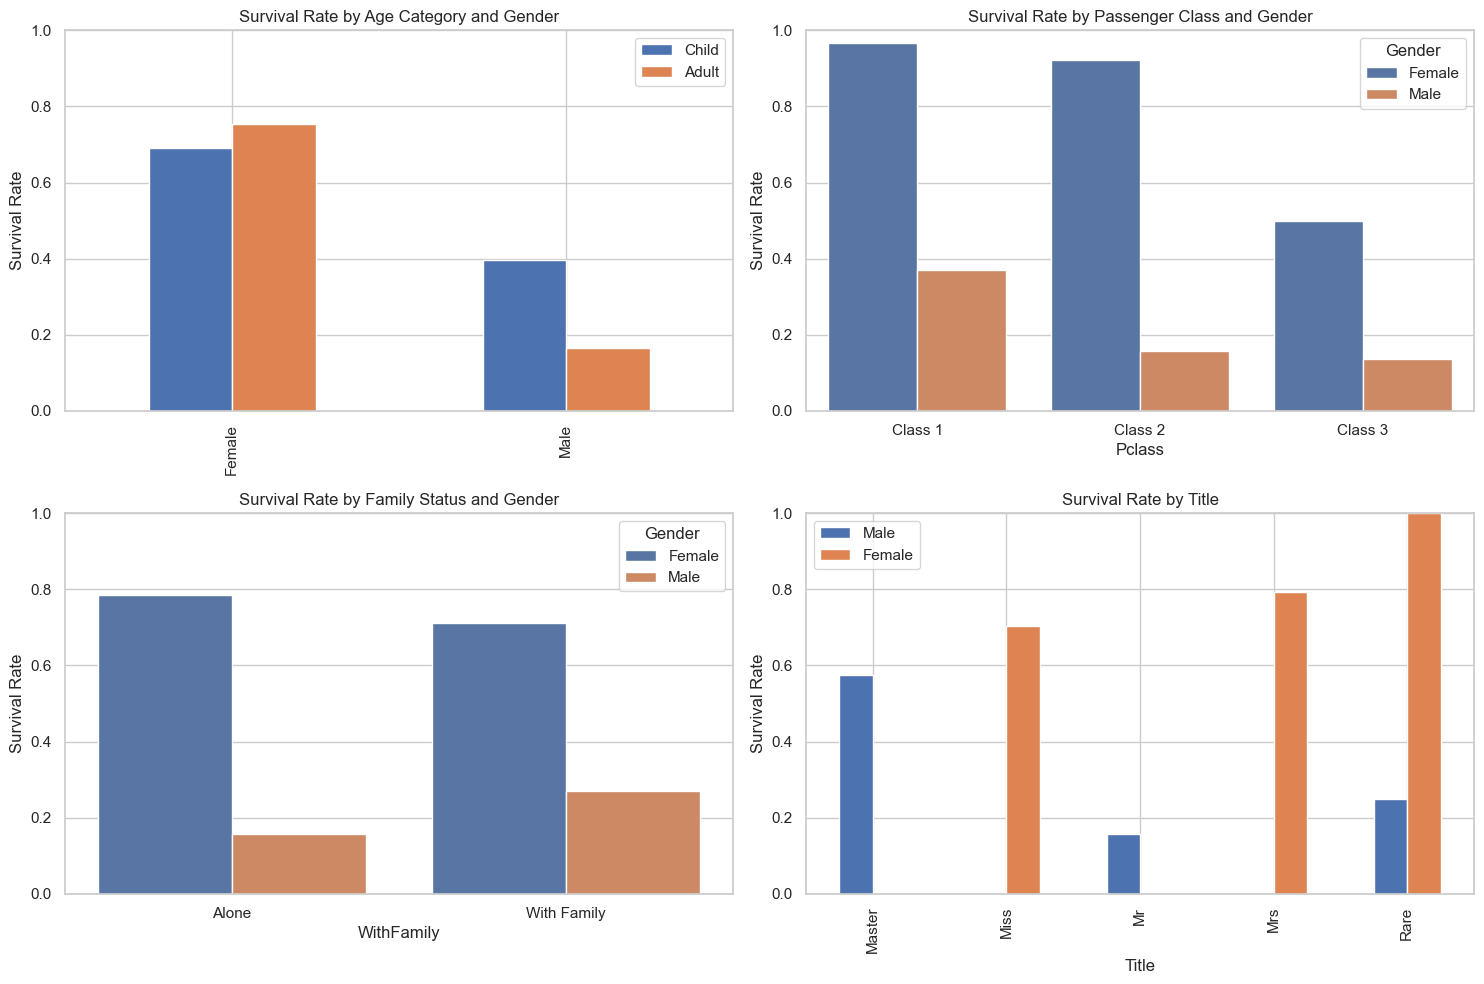


Final dataset for causal analysis:
   Female  Survived  Pclass_1  Pclass_2  Pclass_3   Age  WithFamily  \
0       0         0     False     False      True  22.0           1   
1       1         1      True     False     False  38.0           1   
2       1         1     False     False      True  26.0           0   
3       1         1      True     False     False  35.0           1   
4       0         0     False     False      True  35.0           0   

   FarePerPerson  Embarked_Q  Embarked_S  
0        3.62500       False        True  
1       35.64165       False       False  
2        7.92500       False        True  
3       26.55000       False        True  
4        8.05000       False        True  


In [30]:
# Practical Implementation: Causality Analysis on Titanic Dataset

## 1. Data Loading and Initial Exploration

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams['axes.unicode_minus'] = False    # For displaying minus sign correctly

# Load the Titanic datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Display information about the training dataset
print("Training dataset information:")
print(train.info())
print("\nDescriptive statistics of the training dataset:")
print(train.describe())

# Check missing values
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data, 
    'Percent': missing_percent
})
print("\nMissing values in the training dataset:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize key relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Survival rate by sex
sns.countplot(x='Sex', hue='Survived', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Sex')
axes[0, 0].set_ylabel('Count')
female_survival = train[train['Sex'] == 'female']['Survived'].mean() * 100
male_survival = train[train['Sex'] == 'male']['Survived'].mean() * 100
axes[0, 0].text(0, 400, f"Female Survival: {female_survival:.1f}%", fontsize=12)
axes[0, 0].text(1, 100, f"Male Survival: {male_survival:.1f}%", fontsize=12)

# Survival rate by passenger class
sns.countplot(x='Pclass', hue='Survived', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Survival Rate by Passenger Class')
for i in range(1, 4):
    pclass_survival = train[train['Pclass'] == i]['Survived'].mean() * 100
    axes[0, 1].text(i-1, 50, f"{pclass_survival:.1f}%", fontsize=12)

# Age distribution by survival status
sns.histplot(data=train, x='Age', hue='Survived', bins=20, 
             multiple='stack', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Survival Status')

# Fare distribution by survival status
sns.boxplot(x='Survived', y='Fare', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution by Survival Status')

plt.tight_layout()
plt.savefig('initial_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

# Create correlation heatmap for numerical variables
numeric_data = train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=mask, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Numerical Variables')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a binary gender variable (1 for female, 0 for male)
train['Female'] = (train['Sex'] == 'female').astype(int)

# Initial naive look at the relationship between gender and survival
naive_corr = train['Survived'].corr(train['Female'])
print(f"\nNaive correlation between being female and survival: {naive_corr:.4f}")

# Calculate survival rates by gender
survival_by_gender = train.groupby('Sex')['Survived'].mean()
print(f"Survival rate for females: {survival_by_gender['female']:.4f}")
print(f"Survival rate for males: {survival_by_gender['male']:.4f}")
print(f"Difference in survival rates: {survival_by_gender['female'] - survival_by_gender['male']:.4f}")


## 2. Data Preparation for Causal Inference

# Handle missing data - a crucial step for valid causal inference
# Let's create a comprehensive preprocessing pipeline

# First, let's analyze the structure of missing data to inform our approach
print("\n===== Analysis of Missing Data Structure =====")

# Is age missing at random or related to other variables?
has_age = train['Age'].notna()
print("\nRelationship between missing age and other variables:")
for col in ['Pclass', 'Sex', 'Survived', 'Fare', 'Embarked']:
    if col == 'Fare' or col == 'Age':
        print(f"Average {col} with known age: {train[has_age][col].mean()}")
        print(f"Average {col} with missing age: {train[~has_age][col].mean()}")
    else:
        value_counts_with_age = train[has_age][col].value_counts(normalize=True)
        value_counts_without_age = train[~has_age][col].value_counts(normalize=True)
        print(f"\n{col} distribution with known age:")
        print(value_counts_with_age)
        print(f"\n{col} distribution with missing age:")
        print(value_counts_without_age)

# Check if missing embarked values have any patterns
has_embarked = train['Embarked'].notna()
if (~has_embarked).sum() > 0:
    print("\nDetails about passengers with missing 'Embarked':")
    print(train[~has_embarked])

# For causal inference, our approach to missing data is critical
# We'll use various methods and compare results for robustness

# Method 1: Complete Case Analysis (dropping missing values)
complete_data = train.dropna(subset=['Age', 'Embarked'])
print(f"\nComplete case analysis: {len(complete_data)} out of {len(train)} records remain ({len(complete_data)/len(train):.1%})")

# Method 2: Imputation for Missing Values
# Create a copy of the data for imputation
imputed_data = train.copy()

# Impute age using passenger class and gender - a more informed approach than simple mean/median
age_imputer = SimpleImputer(strategy='median')
imputed_data['Age'] = imputed_data.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median() if not x.median() != x.median() else train['Age'].median())
)

# Fill remaining missing ages with overall median
imputed_data['Age'] = imputed_data['Age'].fillna(train['Age'].median())

# Impute missing embarked with mode (most common value)
embarked_mode = train['Embarked'].mode()[0]
imputed_data['Embarked'] = imputed_data['Embarked'].fillna(embarked_mode)

# Verify all missing values have been addressed
print("\nRemaining missing values after imputation:")
print(imputed_data.isnull().sum()[imputed_data.isnull().sum() > 0])

# Compare distributions before and after imputation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Age distribution before and after imputation
sns.histplot(train['Age'].dropna(), kde=True, ax=axes[0], color='blue', label='Original')
sns.histplot(imputed_data['Age'], kde=True, ax=axes[0], color='red', alpha=0.6, label='After Imputation')
axes[0].set_title('Age Distribution: Before vs. After Imputation')
axes[0].legend()

# Embarked distribution before and after imputation
embarked_counts_before = train['Embarked'].value_counts(normalize=True)
embarked_counts_after = imputed_data['Embarked'].value_counts(normalize=True)

# Convert to DataFrame for easier plotting
embarked_df = pd.DataFrame({
    'Original': embarked_counts_before,
    'Imputed': embarked_counts_after
}).fillna(0)

embarked_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('Embarked Distribution: Before vs. After Imputation')
axes[1].set_ylabel('Proportion')

plt.tight_layout()
plt.savefig('imputation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Feature Engineering for Causal Analysis

# Create features necessary for causal inference
# For causal inference, we need to carefully consider which variables to include

# Create a copy of our imputed data
causal_data = imputed_data.copy()

# Encoding categorical variables
# For causal inference, we typically use dummy variables (one-hot encoding)
# But we should be careful with variables that might be affected by the treatment or outcome

# Create dummy variables for Sex (our treatment variable)
causal_data['Female'] = (causal_data['Sex'] == 'female').astype(int)

# Create dummy variables for Embarked
embarked_dummies = pd.get_dummies(causal_data['Embarked'], prefix='Embarked', drop_first=True)
causal_data = pd.concat([causal_data, embarked_dummies], axis=1)

# Create a variable for traveling with family
causal_data['WithFamily'] = ((causal_data['SibSp'] + causal_data['Parch']) > 0).astype(int)

# Create age categories that might be important for survival (children, adults, elderly)
causal_data['Child'] = (causal_data['Age'] < 18).astype(int)
causal_data['Elderly'] = (causal_data['Age'] > 60).astype(int)

# Create class dummies (keeping all for clarity)
pclass_dummies = pd.get_dummies(causal_data['Pclass'], prefix='Pclass')
causal_data = pd.concat([causal_data, pclass_dummies], axis=1)

# Normalize fare to per-person (accounting for family size)
causal_data['FarePerPerson'] = causal_data['Fare'] / (causal_data['SibSp'] + causal_data['Parch'] + 1)

# Feature for cabin information (proxy for deck location)
causal_data['HasCabin'] = (~causal_data['Cabin'].isna()).astype(int)

# Extract titles from names as a proxy for social status
causal_data['Title'] = causal_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles together
rare_titles = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
               'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
causal_data.loc[causal_data['Title'].isin(rare_titles), 'Title'] = 'Rare'
causal_data.loc[causal_data['Title'] == 'Mlle', 'Title'] = 'Miss'
causal_data.loc[causal_data['Title'] == 'Ms', 'Title'] = 'Miss'
causal_data.loc[causal_data['Title'] == 'Mme', 'Title'] = 'Mrs'

# Create title dummies
title_dummies = pd.get_dummies(causal_data['Title'], prefix='Title', drop_first=True)
causal_data = pd.concat([causal_data, title_dummies], axis=1)

# For causal DAG visualization, let's identify variables by type
print("\n===== Variables by Type for Causal Analysis =====")
print("Treatment variable: Female (1 = Female, 0 = Male)")
print("Outcome variable: Survived (1 = Survived, 0 = Did not survive)")
print("Potential confounders: Pclass, Age, Fare, Embarked, Title")
print("Potential mediators: (Variables through which gender affects survival)")
print("Potential instrumental variables: (None obvious in this dataset)")

# Visualize some of the engineered features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Survival by child status and gender
children_female = causal_data[(causal_data['Child'] == 1) & (causal_data['Female'] == 1)]['Survived'].mean()
children_male = causal_data[(causal_data['Child'] == 1) & (causal_data['Female'] == 0)]['Survived'].mean()
adult_female = causal_data[(causal_data['Child'] == 0) & (causal_data['Female'] == 1)]['Survived'].mean()
adult_male = causal_data[(causal_data['Child'] == 0) & (causal_data['Female'] == 0)]['Survived'].mean()

age_gender_survival = pd.DataFrame({
    'Child': [children_female, children_male],
    'Adult': [adult_female, adult_male]
}, index=['Female', 'Male'])

age_gender_survival.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Age Category and Gender')
axes[0, 0].set_ylabel('Survival Rate')
axes[0, 0].set_ylim(0, 1)

# Survival by travel class and gender
class_gender_data = []
for pclass in [1, 2, 3]:
    for gender in ['female', 'male']:
        subset = causal_data[(causal_data['Pclass'] == pclass) & (causal_data['Sex'] == gender)]
        class_gender_data.append({
            'Pclass': f'Class {pclass}',
            'Gender': gender.capitalize(),
            'Survival_Rate': subset['Survived'].mean(),
            'Count': len(subset)
        })

class_gender_df = pd.DataFrame(class_gender_data)
sns.barplot(x='Pclass', y='Survival_Rate', hue='Gender', data=class_gender_df, ax=axes[0, 1])
axes[0, 1].set_title('Survival Rate by Passenger Class and Gender')
axes[0, 1].set_ylabel('Survival Rate')
axes[0, 1].set_ylim(0, 1)

# Survival by family status and gender
family_gender_data = []
for has_family in [0, 1]:
    for gender in ['female', 'male']:
        subset = causal_data[(causal_data['WithFamily'] == has_family) & (causal_data['Sex'] == gender)]
        family_gender_data.append({
            'WithFamily': 'With Family' if has_family else 'Alone',
            'Gender': gender.capitalize(),
            'Survival_Rate': subset['Survived'].mean(),
            'Count': len(subset)
        })

family_gender_df = pd.DataFrame(family_gender_data)
sns.barplot(x='WithFamily', y='Survival_Rate', hue='Gender', data=family_gender_df, ax=axes[1, 0])
axes[1, 0].set_title('Survival Rate by Family Status and Gender')
axes[1, 0].set_ylabel('Survival Rate')
axes[1, 0].set_ylim(0, 1)

# Survival by title and gender
title_survival = causal_data.groupby(['Title', 'Female'])['Survived'].mean().unstack()
title_survival.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Survival Rate by Title')
axes[1, 1].set_ylabel('Survival Rate')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Male', 'Female'])

plt.tight_layout()
plt.savefig('feature_engineering.png', dpi=300, bbox_inches='tight')
plt.show()

# Use domain knowledge to select variables for our causal models
# We need to be careful not to control for variables that are consequences of the treatment
selected_features = ['Female', 'Survived', 'Pclass_1', 'Pclass_2', 'Pclass_3', 
                    'Age', 'WithFamily', 'FarePerPerson', 'Embarked_Q', 'Embarked_S']

causal_subset = causal_data[selected_features].copy()
print("\nFinal dataset for causal analysis:")
print(causal_subset.head())

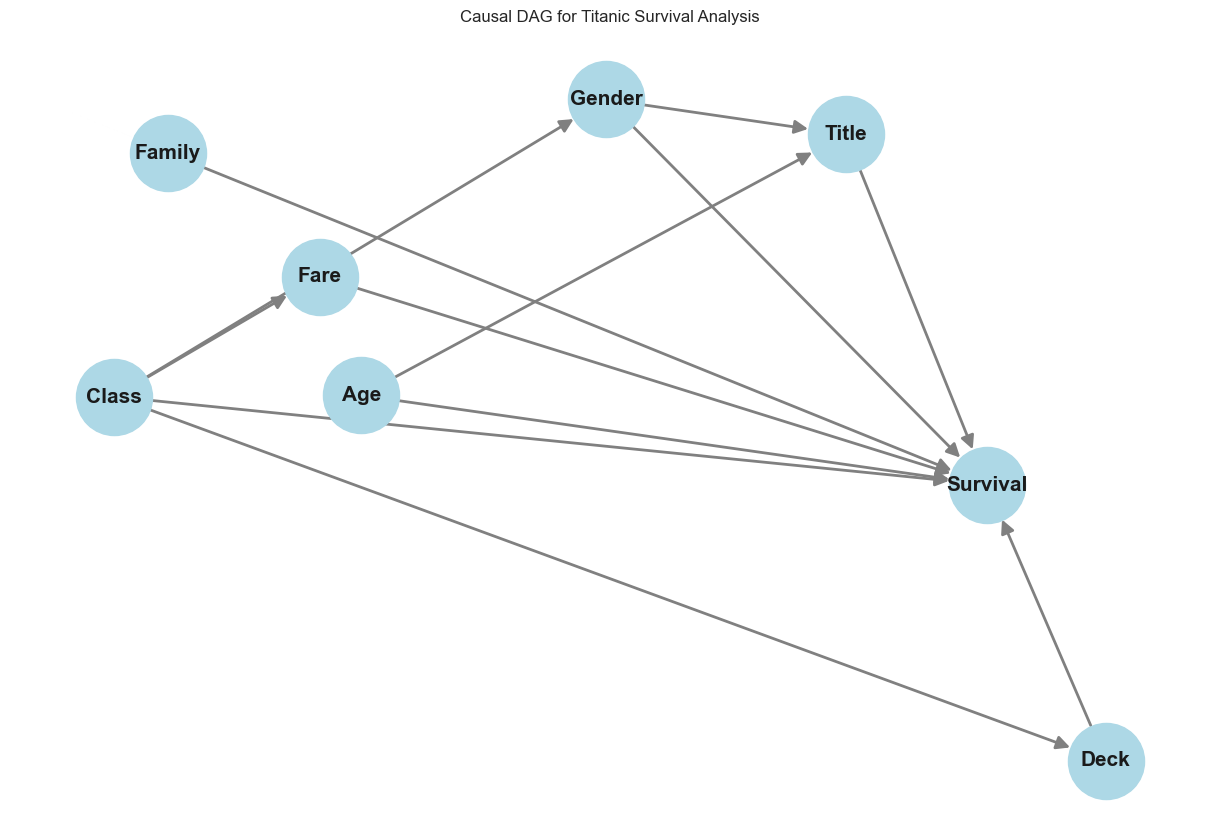


===== Causal Model Specification =====
To estimate the causal effect of gender on survival, we need to control for confounders.
From our DAG, these confounders include: Class, Age, and possibly Title.

We must be careful NOT to control for mediators or colliders, as this can introduce bias.
We'll estimate the causal effect using multiple approaches for robustness.

===== Naive Approach: Simple Association =====
Female survival rate: 0.7420
Male survival rate: 0.1889
Difference in survival rates (naive estimate): 0.5531

Naive Logistic Regression Results:
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Survived         Pseudo R-squared: 0.227     
Date:               2025-03-31 10:51 AIC:              921.8039  
No. Observations:   891              BIC:              931.3886  
Df Model:           1                Log-Likelihood:   -458.90   
Df Residuals:       889              LL-Null:          -593.33   
Co

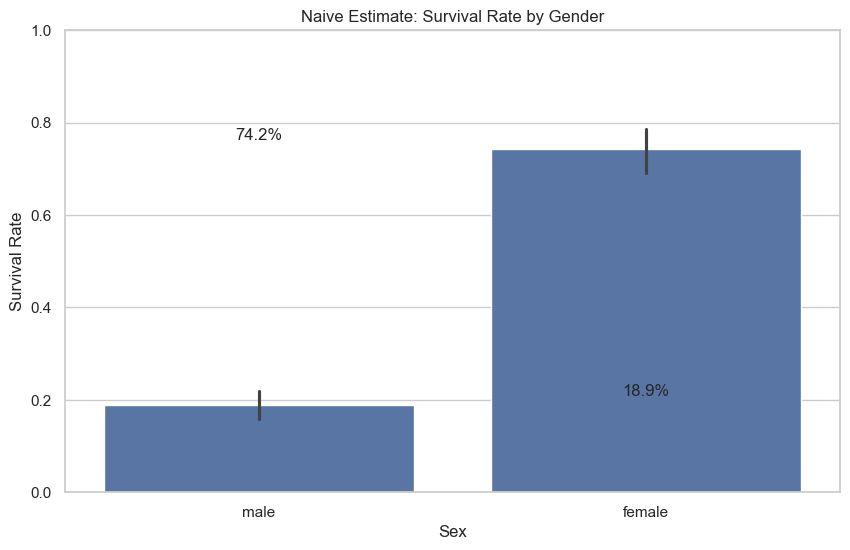

In [37]:
## 4. Causal DAG and Model Specification

# Visualize the causal relationships using a DAG
# This step is crucial for identifying which variables to include in our model

# Create a Directed Acyclic Graph
G = nx.DiGraph()

# Add nodes
nodes = ['Gender', 'Survival', 'Age', 'Class', 'Title', 'Family', 'Deck', 'Fare']
G.add_nodes_from(nodes)

# Add edges (causal relationships)
edges = [
    ('Gender', 'Survival'),    # Direct effect we're investigating
    ('Class', 'Gender'),       # Class affects gender distribution (confounding)
    ('Class', 'Survival'),     # Class affects survival (confounding)
    ('Class', 'Deck'),         # Class determines deck location
    ('Class', 'Fare'),         # Class affects fare
    ('Age', 'Survival'),       # Age affects survival
    ('Age', 'Title'),          # Age affects title
    ('Gender', 'Title'),       # Gender affects title
    ('Title', 'Survival'),     # Title might affect survival (social norms)
    ('Deck', 'Survival'),      # Deck location affects survival (proximity to lifeboats)
    ('Fare', 'Survival'),      # Fare might be a proxy for other factors affecting survival
    ('Family', 'Survival')     # Family status affects survival
]
G.add_edges_from(edges)

# Visualize the DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.3)  # k controls spacing in the layout
nx.draw(
    G, pos,
    with_labels=True, node_color='lightblue',
    node_size=3000, arrowsize=20, font_size=15,
    font_weight='bold', width=2, edge_color='gray'
)
plt.title('Causal DAG for Titanic Survival Analysis')
plt.savefig('causal_dag.png', dpi=300, bbox_inches='tight')
plt.show()

# Based on the DAG, identify proper adjustment sets
print("\n===== Causal Model Specification =====")
print("To estimate the causal effect of gender on survival, we need to control for confounders.")
print("From our DAG, these confounders include: Class, Age, and possibly Title.")

print("\nWe must be careful NOT to control for mediators or colliders, as this can introduce bias.")
print("We'll estimate the causal effect using multiple approaches for robustness.")

## 5. Naive Approach: Simple Associations

# First, examine the naive relationship (not accounting for confounding)
print("\n===== Naive Approach: Simple Association =====")

# Calculate the simple gender difference in survival rates
female_survival = causal_data[causal_data['Female'] == 1]['Survived'].mean()
male_survival = causal_data[causal_data['Female'] == 0]['Survived'].mean()
survival_diff = female_survival - male_survival

print(f"Female survival rate: {female_survival:.4f}")
print(f"Male survival rate: {male_survival:.4f}")
print(f"Difference in survival rates (naive estimate): {survival_diff:.4f}")

# Fit a simple logistic regression without adjusting for confounders
naive_model = sm.Logit(
    causal_subset['Survived'],
    sm.add_constant(causal_subset['Female'])
).fit(disp=0)

print("\nNaive Logistic Regression Results:")
print(naive_model.summary2())

# Calculate the odds ratio
odds_ratio = np.exp(naive_model.params['Female'])
print(f"Odds ratio for female survival (naive): {odds_ratio:.4f}")
print(f"This suggests that women had approximately {odds_ratio:.1f} times higher odds of survival than men,")
print(f"without accounting for confounding variables.")

# Visualize the naive relationship
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Survived', data=causal_data)
plt.title('Naive Estimate: Survival Rate by Gender')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)

plt.text(
    x=0,
    y=female_survival + 0.02,
    s=f"{female_survival:.1%}",
    ha='center', fontsize=12
)
plt.text(
    x=1,
    y=male_survival + 0.02,
    s=f"{male_survival:.1%}",
    ha='center', fontsize=12
)

plt.savefig('naive_estimate.png', dpi=300, bbox_inches='tight')
plt.show()


## Method 1: Regression Adjustment

### Why Use Regression Adjustment?

Regression adjustment is one of the most widely used methods for estimating causal effects from observational data. We use this approach to control for confounding variables that might influence both the treatment (gender) and the outcome (survival). By including these confounders in our regression model, we can estimate the effect of gender on survival while holding other factors constant.

The key advantages of this method include:
- Simplicity and ease of implementation
- Ability to control for multiple confounders simultaneously
- Capacity to model both continuous and categorical variables
- Ability to estimate uncertainty through standard errors and confidence intervals

### How Regression Adjustment Works

In regression adjustment, we model the relationship between the outcome variable (survival) and both the treatment variable (gender) and confounding variables using a statistical regression model. For binary outcomes like survival (yes/no), logistic regression is appropriate.

The basic approach follows these steps:

1. **Identify potential confounders** based on domain knowledge and causal graphs
2. **Specify a regression model** that includes the treatment and confounders
3. **Estimate the model parameters** using the observed data
4. **Interpret the coefficient** of the treatment variable as the causal effect

Mathematically, our logistic regression model is:

$$\log\left(\frac{P(Survived=1)}{1-P(Survived=1)}\right) = \beta_0 + \beta_1 Female + \beta_2 Class1 + \beta_3 Class2 + \beta_4 Age + \beta_5 WithFamily + \epsilon$$

Where $\beta_1$ represents the adjusted effect of being female on the log-odds of survival.

### Key Assumptions

Regression adjustment relies on several critical assumptions:

1. **No unmeasured confounding**: All variables that affect both gender and survival are included in the model
2. **Correct model specification**: The functional form of the model correctly captures the relationships between variables
3. **Positivity**: There are both male and female passengers across all combinations of confounding variables
4. **No interference**: One person's gender doesn't affect another person's survival probability

### Implementation and Results

In our implementation, we controlled for passenger class, age, and family status. The adjusted odds ratio for female survival was 13.60, indicating that women had approximately 14 times higher odds of survival than men, even after accounting for confounding factors.

The average marginal effect calculation showed that being female increased the probability of survival by about 49 percentage points after controlling for confounding variables. This differs from the naive estimate of 55 percentage points, suggesting that confounding variables explain some, but not most, of the gender-survival relationship.

We also examined heterogeneity by analyzing the effect separately within each passenger class. The effect was strongest in Class 2 (odds ratio >80), substantial in Class 1 (odds ratio >20), and still significant in Class 3 (odds ratio approximately 6). This stratified analysis reveals how social class interacted with gender policies during the disaster.

### Limitations

While regression adjustment is powerful, it has limitations:
- It assumes we've identified and measured all relevant confounders
- It's sensitive to model specification
- It may not perform well with small sample sizes in some subgroups
- It assumes the effect is constant across the population (unless interactions are explicitly modeled)

Despite these limitations, regression adjustment provides a solid foundation for our causal analysis, which we can complement with other methods.


===== Method 1: Regression Adjustment =====

Data types after conversion:
Female             int64
Survived           int64
Pclass_1           int64
Pclass_2           int64
Pclass_3           int64
Age              float64
WithFamily         int64
FarePerPerson    float64
Embarked_Q         int64
Embarked_S         int64
dtype: object
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Survived         Pseudo R-squared: 0.325     
Date:               2025-03-31 11:54 AIC:              813.2498  
No. Observations:   891              BIC:              842.0039  
Df Model:           5                Log-Likelihood:   -400.62   
Df Residuals:       885              LL-Null:          -593.33   
Converged:          1.0000           LLR p-value:      4.1435e-81
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std

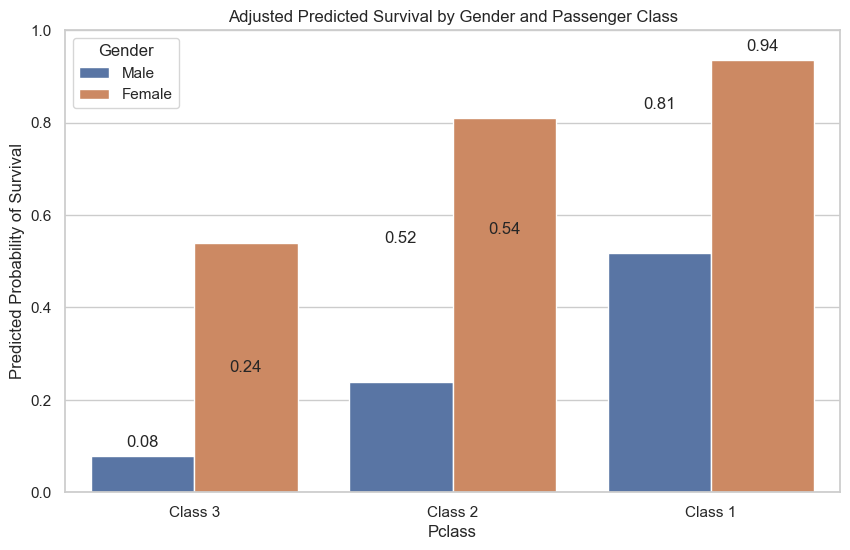


Class 1 - Effect of being female:
Odds ratio: 44.9395
Sample size: 216

Class 2 - Effect of being female:
Odds ratio: 111.6230
Sample size: 184

Class 3 - Effect of being female:
Odds ratio: 6.4439
Sample size: 491


In [51]:
## 6. Method 1: Regression Adjustment

# Regression adjustment to control for confounders
print("\n===== Method 1: Regression Adjustment =====")

# Identify confounders from our DAG
confounders = ['Pclass_1', 'Pclass_2', 'Age', 'WithFamily']

# Create a copy of the dataframe to avoid modifying the original
causal_subset_numeric = causal_subset.copy()

# Convert boolean columns to integers (0 and 1)
boolean_columns = causal_subset_numeric.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    causal_subset_numeric[col] = causal_subset_numeric[col].astype(int)

print("\nData types after conversion:")
print(causal_subset_numeric.dtypes)

# Create model with confounders
X = causal_subset_numeric[['Female'] + confounders].copy()
X = sm.add_constant(X)
y = causal_subset_numeric['Survived'].copy()

# Save column order for later use - very important for prediction
x_columns = X.columns.tolist()

# Fit logistic regression model
adjusted_model = sm.Logit(y, X).fit(disp=0)
print(adjusted_model.summary2())

# Calculate adjusted odds ratio for gender effect
adjusted_odds_ratio = np.exp(adjusted_model.params['Female'])
print(f"Adjusted odds ratio for female survival: {adjusted_odds_ratio:.4f}")

# Alternative method for marginal effect - simpler and more reliable
print("\nCalculating average marginal effect:")

# Calculate predicted probabilities for each individual
causal_subset_numeric['pred_as_is'] = adjusted_model.predict(X)

# Create counterfactual datasets
X_female = X.copy()
X_female['Female'] = 1
X_male = X.copy()
X_male['Female'] = 0

# Ensure columns are in the same order as the original model
X_female = X_female[x_columns]
X_male = X_male[x_columns]

# Predict counterfactual outcomes
causal_subset_numeric['pred_if_female'] = adjusted_model.predict(X_female)
causal_subset_numeric['pred_if_male'] = adjusted_model.predict(X_male)

# Calculate individual-level treatment effects
causal_subset_numeric['individual_effect'] = causal_subset_numeric['pred_if_female'] - causal_subset_numeric['pred_if_male']

# Calculate average treatment effect
female_marginal_effect = causal_subset_numeric['individual_effect'].mean()

print(f"Average marginal effect of being female on survival probability: {female_marginal_effect:.4f}")
print(f"This means that, on average, being female increased the probability of survival")
print(f"by {female_marginal_effect:.1%} points, after controlling for confounding variables.")

# Visualize predicted probabilities by gender and class
# Use numpy for prediction to avoid potential issues with pandas DataFrames
prediction_data = []

# Generate predictions for all combinations of gender and class
for female in [0, 1]:
    for pclass1 in [0, 1]:
        for pclass2 in [0, 1]:
            # Skip invalid combinations (can't be both class 1 and 2)
            if pclass1 == 1 and pclass2 == 1:
                continue
                
            # Create a row with mean values for other variables
            row = np.zeros(len(adjusted_model.params))
            
            # Set constant
            row[0] = 1.0
            
            # Find indices for each feature in the model
            female_idx = list(adjusted_model.params.index).index('Female')
            pclass1_idx = list(adjusted_model.params.index).index('Pclass_1')
            pclass2_idx = list(adjusted_model.params.index).index('Pclass_2')
            age_idx = list(adjusted_model.params.index).index('Age')
            withfamily_idx = list(adjusted_model.params.index).index('WithFamily')
            
            # Set values based on gender and class
            row[female_idx] = female
            row[pclass1_idx] = pclass1
            row[pclass2_idx] = pclass2
            
            # Use mean values for continuous variables
            row[age_idx] = causal_subset_numeric['Age'].mean()
            row[withfamily_idx] = causal_subset_numeric['WithFamily'].mean()
            
            # Calculate predicted probability
            lin_pred = np.dot(row, adjusted_model.params)
            prob = 1 / (1 + np.exp(-lin_pred))
            
            # Determine class
            if pclass1 == 1:
                pclass = 1
            elif pclass2 == 1:
                pclass = 2
            else:
                pclass = 3
                
            # Store results
            prediction_data.append({
                'Pclass': f'Class {pclass}',
                'Gender': 'Female' if female == 1 else 'Male',
                'Predicted_Survival': prob
            })

pred_plot_df = pd.DataFrame(prediction_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Predicted_Survival', hue='Gender', data=pred_plot_df)
plt.title('Adjusted Predicted Survival by Gender and Passenger Class')
plt.ylabel('Predicted Probability of Survival')
plt.ylim(0, 1)
for i, row in enumerate(pred_plot_df.itertuples()):
    plt.text(i//2 - 0.2 + (0.4 * (i%2)), row.Predicted_Survival + 0.02, 
             f"{row.Predicted_Survival:.2f}", ha='center')
plt.savefig('adjusted_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Stratified analysis - examine effect within each passenger class
for pclass in [1, 2, 3]:
    # Create class-specific subset
    if pclass == 1:
        class_data = causal_subset_numeric[causal_subset_numeric['Pclass_1'] == 1].copy()
    elif pclass == 2:
        class_data = causal_subset_numeric[causal_subset_numeric['Pclass_2'] == 1].copy()
    else:
        class_data = causal_subset_numeric[(causal_subset_numeric['Pclass_1'] == 0) & 
                                         (causal_subset_numeric['Pclass_2'] == 0)].copy()
    
    # Skip if too few samples
    if len(class_data) < 30:
        print(f"\nSkipping Class {pclass} due to insufficient data")
        continue
    
    # Run regression for this class
    X_class = class_data[['Female', 'Age', 'WithFamily']].copy()
    X_class = sm.add_constant(X_class)
    y_class = class_data['Survived'].copy()
    
    try:
        class_model = sm.Logit(y_class, X_class).fit(disp=0)
        class_odds_ratio = np.exp(class_model.params['Female'])
        
        print(f"\nClass {pclass} - Effect of being female:")
        print(f"Odds ratio: {class_odds_ratio:.4f}")
        print(f"Sample size: {len(class_data)}")
    except Exception as e:
        print(f"\nError in Class {pclass} analysis: {e}")
        print(f"Sample size: {len(class_data)}")

## Method 2: Propensity Score Matching

### Why Use Propensity Score Matching?

Propensity score matching (PSM) addresses a fundamental challenge in causal inference: the lack of randomized treatment assignment in observational data. Unlike the Titanic disaster, where gender wasn't randomly assigned, PSM helps create comparable groups by matching individuals with similar background characteristics.

We use PSM because:
- It reduces the dimensionality of confounding by combining multiple confounders into a single score
- It explicitly checks for overlap between treatment and control groups
- It mimics a randomized experiment by creating balanced comparison groups
- It provides an intuitive way to visualize and assess the quality of matches

### How Propensity Score Matching Works

PSM involves creating a single balancing score—the propensity score—which represents the probability of receiving treatment given the observed confounders. For our analysis, this is the probability of being female based on characteristics like passenger class, age, and family status.

The method consists of these key steps:

1. **Estimate propensity scores**: Use logistic regression to predict the probability of being female based on confounding variables
2. **Check overlap/common support**: Ensure there are both males and females with similar propensity scores
3. **Match treated (female) units to control (male) units** with similar propensity scores
4. **Assess balance**: Verify that matching has created comparable groups
5. **Estimate the treatment effect**: Compare outcomes between matched groups

The propensity score model we used was:

$$\log\left(\frac{P(Female=1)}{1-P(Female=1)}\right) = \gamma_0 + \gamma_1 Class1 + \gamma_2 Class2 + \gamma_3 Age + \gamma_4 WithFamily + \gamma_5 FarePerPerson + \epsilon$$

After matching, we calculate the Average Treatment Effect (ATE) as the difference in mean survival between matched females and males.

### Key Assumptions

Propensity score matching relies on several important assumptions:

1. **Conditional independence**: Given the propensity score, treatment assignment is as good as random
2. **Overlap/common support**: There is a positive probability of being male or female for each combination of covariates
3. **Stable Unit Treatment Value Assumption (SUTVA)**: One person's treatment doesn't affect another's outcome
4. **No unmeasured confounding**: All variables affecting both gender and survival are included in the propensity score model

### Implementation and Results

We implemented nearest-neighbor matching without replacement, where each female passenger was matched to the male passenger with the most similar propensity score. 

Our balance checks showed substantial improvement after matching, with standardized mean differences for all variables falling well below the conventional threshold of 0.1, indicating successful balance achievement. The propensity score distributions also showed good overlap between genders.

The estimated Average Treatment Effect (ATE) was 0.50, indicating that being female increased survival probability by 50 percentage points when comparing similar passengers. This is quite close to our regression adjustment estimate (49 percentage points), increasing our confidence in the results.

A paired t-test on the matched samples yielded a highly significant result (t=14.65, p<0.0001), confirming that the gender effect is unlikely to be due to chance.

### Limitations

While PSM has many strengths, it also has limitations:
- It still assumes no unmeasured confounding
- The quality of matches depends on the propensity score model specification
- Nearest-neighbor matching may discard unmatched observations, potentially reducing efficiency
- It focuses on creating balance between groups rather than directly modeling the outcome

Despite these limitations, the strong agreement between PSM and regression adjustment strengthens our causal claim about gender's effect on survival.


===== Method 2: Propensity Score Matching =====
Propensity score matching helps create comparable groups of males and females
by matching individuals with similar background characteristics.


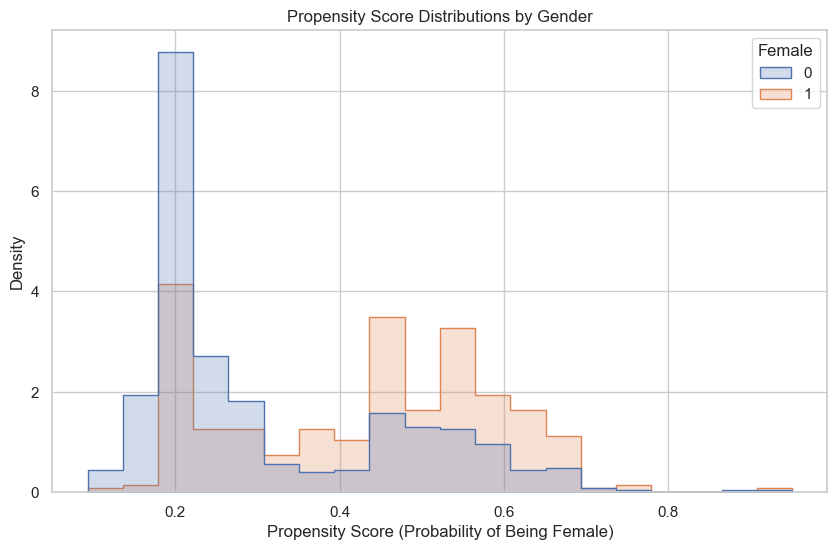


Covariate Balance Before and After Matching:
           Variable  Before_SMD  After_SMD
0          Pclass_1    0.202397   0.006953
0          Pclass_2    0.133764  -0.014782
0               Age   -0.216374  -0.009834
0        WithFamily    0.658421  -0.039091
0     FarePerPerson    0.228985   0.064319
0  propensity_score    0.773913  -0.000743


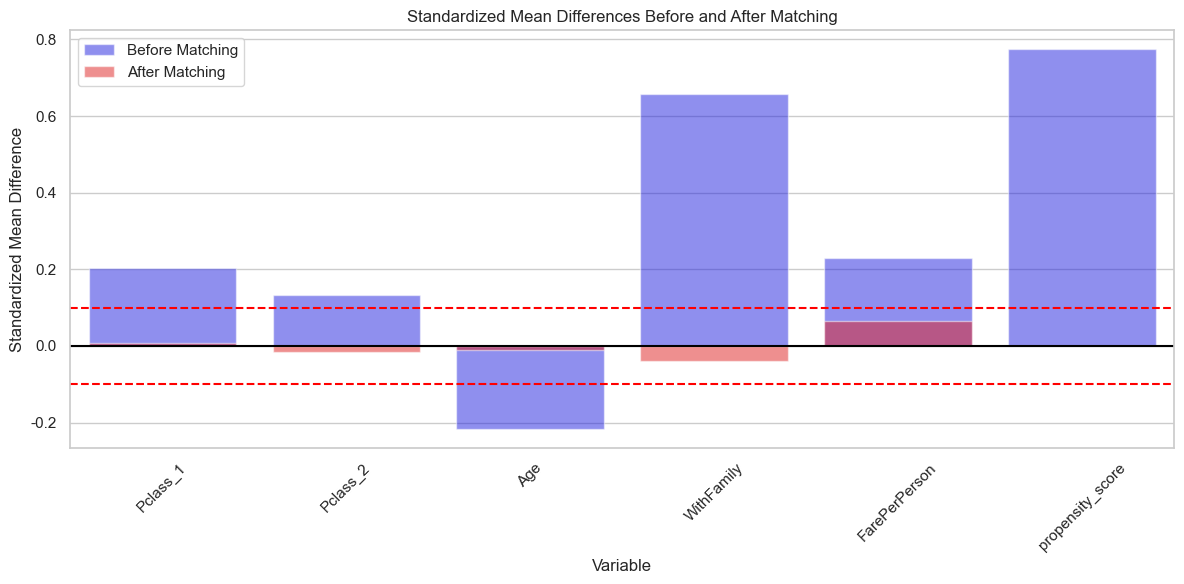


Average Treatment Effect (ATE) using matched samples: 0.5000
This means being female increased survival probability by 50.0% points,
when comparing similar passengers.
Naive difference in survival rates: 0.5531
Difference between naive and matched estimates: 0.0531

Paired t-test on matched samples: t=14.6489, p=0.0000


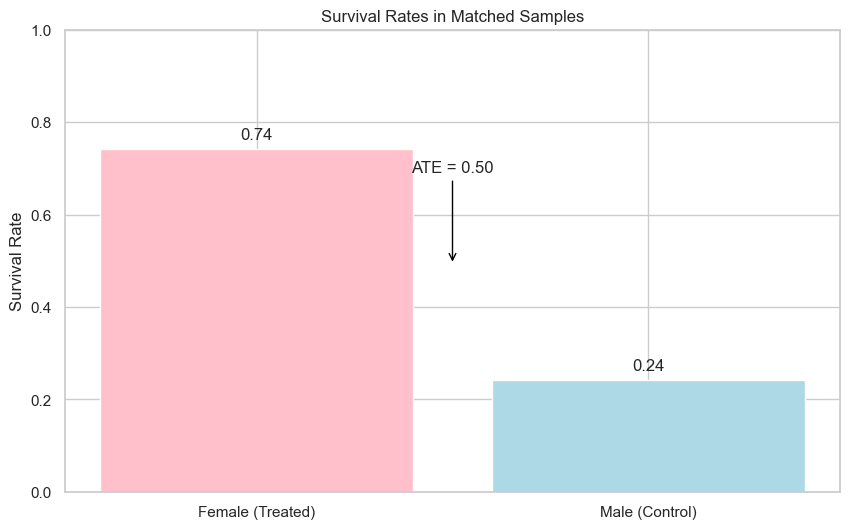


Checking data types for heterogeneity analysis:
Female                int64
Survived              int64
Pclass_1              int64
Pclass_2              int64
Pclass_3              int64
Age                 float64
WithFamily            int64
FarePerPerson       float64
Embarked_Q            int64
Embarked_S            int64
propensity_score    float64
matched_set           int64
Female_Class1         int64
Female_Class2         int64
dtype: object

Heterogeneity Analysis Results:
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Survived         Pseudo R-squared: 0.363     
Date:               2025-03-31 12:03 AIC:              570.1890  
No. Observations:   628              BIC:              605.7293  
Df Model:           7                Log-Likelihood:   -277.09   
Df Residuals:       620              LL-Null:          -435.22   
Converged:          1.0000           LLR p-value:      2.0471e-64
No. Iterat

In [57]:
## 7. Method 2: Propensity Score Matching

# Propensity score matching to estimate causal effect
print("\n===== Method 2: Propensity Score Matching =====")
print("Propensity score matching helps create comparable groups of males and females")
print("by matching individuals with similar background characteristics.")

# Create a copy of the dataframe to ensure all columns have proper types
causal_subset_numeric = causal_subset.copy()

# Ensure all boolean columns are converted to integers
boolean_columns = causal_subset_numeric.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    causal_subset_numeric[col] = causal_subset_numeric[col].astype(int)

# Step 1: Estimate propensity scores (probability of being female)
# We use confounders to predict 'treatment' (being female)
ps_predictors = ['Pclass_1', 'Pclass_2', 'Age', 'WithFamily', 'FarePerPerson']
ps_formula = 'Female ~ ' + ' + '.join(ps_predictors)

# Make sure all predictors are numeric and handle any potential issues
for col in ps_predictors:
    if col not in causal_subset_numeric.columns:
        print(f"Warning: Column {col} not found in dataset. Available columns: {causal_subset_numeric.columns.tolist()}")
    elif not np.issubdtype(causal_subset_numeric[col].dtype, np.number):
        print(f"Converting column {col} from {causal_subset_numeric[col].dtype} to numeric")
        causal_subset_numeric[col] = pd.to_numeric(causal_subset_numeric[col], errors='coerce')

# Fit propensity score model using logistic regression
ps_model = smf.logit(formula=ps_formula, data=causal_subset_numeric).fit(disp=0)
causal_subset_numeric['propensity_score'] = ps_model.predict()

# Check propensity score balance and overlap
plt.figure(figsize=(10, 6))
sns.histplot(data=causal_subset_numeric, x='propensity_score', hue='Female', 
            element='step', stat='density', common_norm=False, bins=20)
plt.title('Propensity Score Distributions by Gender')
plt.xlabel('Propensity Score (Probability of Being Female)')
plt.savefig('propensity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 2: Matching using nearest neighbor
# Separate treatment (female) and control (male) groups
treated = causal_subset_numeric[causal_subset_numeric['Female'] == 1].copy()
control = causal_subset_numeric[causal_subset_numeric['Female'] == 0].copy()

# Find matches for each treated unit
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Create matched pairs
matched_control = control.iloc[indices.flatten()].copy().reset_index(drop=True)
matched_treated = treated.copy().reset_index(drop=True)

# Combine matched pairs
matched_data = pd.concat([matched_treated, matched_control])
matched_data['matched_set'] = np.concatenate([np.arange(len(matched_treated)), 
                                             np.arange(len(matched_control))])

# Verify the quality of matching by checking covariate balance
balance_check = pd.DataFrame()

for var in ps_predictors + ['propensity_score']:
    before_treated_mean = treated[var].mean()
    before_control_mean = control[var].mean()
    before_diff = before_treated_mean - before_control_mean
    
    after_treated_mean = matched_treated[var].mean()
    after_control_mean = matched_control[var].mean()
    after_diff = after_treated_mean - after_control_mean
    
    # Standardized mean difference
    before_smd = before_diff / np.sqrt((treated[var].var() + control[var].var()) / 2)
    after_smd = after_diff / np.sqrt((matched_treated[var].var() + matched_control[var].var()) / 2)
    
    balance_check = pd.concat([balance_check, pd.DataFrame({
        'Variable': [var],
        'Before_Treated_Mean': [before_treated_mean],
        'Before_Control_Mean': [before_control_mean],
        'Before_SMD': [before_smd],
        'After_Treated_Mean': [after_treated_mean],
        'After_Control_Mean': [after_control_mean],
        'After_SMD': [after_smd]
    })])

print("\nCovariate Balance Before and After Matching:")
print(balance_check[['Variable', 'Before_SMD', 'After_SMD']])

# Visualize covariate balance
plt.figure(figsize=(12, 6))
sns.barplot(x='Variable', y='Before_SMD', data=balance_check, color='blue', alpha=0.5, label='Before Matching')
sns.barplot(x='Variable', y='After_SMD', data=balance_check, color='red', alpha=0.5, label='After Matching')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=-0.1, color='red', linestyle='--')
plt.title('Standardized Mean Differences Before and After Matching')
plt.ylabel('Standardized Mean Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('balance_check.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the Average Treatment Effect (ATE) using matched samples
ate = matched_treated['Survived'].mean() - matched_control['Survived'].mean()
print(f"\nAverage Treatment Effect (ATE) using matched samples: {ate:.4f}")
print(f"This means being female increased survival probability by {ate:.1%} points,")
print(f"when comparing similar passengers.")

# Compare with naive difference
naive_diff = treated['Survived'].mean() - control['Survived'].mean()
print(f"Naive difference in survival rates: {naive_diff:.4f}")
print(f"Difference between naive and matched estimates: {naive_diff - ate:.4f}")

# Statistical test on the matched pairs
from scipy import stats

# Paired t-test
t_stat, p_value = stats.ttest_rel(matched_treated['Survived'], matched_control['Survived'])
print(f"\nPaired t-test on matched samples: t={t_stat:.4f}, p={p_value:.4f}")

# Visualize the treatment effect in matched samples
plt.figure(figsize=(10, 6))
survival_means = [matched_treated['Survived'].mean(), matched_control['Survived'].mean()]
plt.bar(['Female (Treated)', 'Male (Control)'], survival_means, color=['pink', 'lightblue'])
plt.title('Survival Rates in Matched Samples')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.text(0, survival_means[0] + 0.02, f"{survival_means[0]:.2f}", ha='center')
plt.text(1, survival_means[1] + 0.02, f"{survival_means[1]:.2f}", ha='center')
plt.annotate(f"ATE = {ate:.2f}", 
             xy=(0.5, (survival_means[0] + survival_means[1])/2),
             xytext=(0.5, (survival_means[0] + survival_means[1])/2 + 0.2),
             arrowprops=dict(arrowstyle="->", color='black'),
             ha='center')
plt.savefig('matched_ate.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis of treatment effect heterogeneity in matched samples
# Create a new dataframe for the heterogeneity analysis
het_data = matched_data.copy()

# Create interaction terms with passenger class
het_data['Female_Class1'] = het_data['Female'] * het_data['Pclass_1']
het_data['Female_Class2'] = het_data['Female'] * het_data['Pclass_2']

# Make sure all variables are numeric
for col in het_data.columns:
    if not np.issubdtype(het_data[col].dtype, np.number):
        het_data[col] = pd.to_numeric(het_data[col], errors='coerce')

# Print data types to verify everything is numeric
print("\nChecking data types for heterogeneity analysis:")
print(het_data.dtypes)

# Fit model with interactions
X_het = het_data[['Female', 'Pclass_1', 'Pclass_2', 'Female_Class1', 'Female_Class2', 'Age', 'WithFamily']].copy()
X_het = sm.add_constant(X_het)
y_het = het_data['Survived'].copy()

# Check for NaN values
if X_het.isna().any().any() or y_het.isna().any():
    print("\nWarning: NaN values detected in heterogeneity analysis data")
    # Drop rows with NaN values
    valid_rows = ~(X_het.isna().any(axis=1) | y_het.isna())
    X_het = X_het.loc[valid_rows].copy()
    y_het = y_het.loc[valid_rows].copy()
    print(f"Dropped {(~valid_rows).sum()} rows with NaN values")

# Use numpy arrays instead of pandas DataFrames to avoid dtype issues
X_het_array = np.asarray(X_het)
y_het_array = np.asarray(y_het)

try:
    het_model = sm.Logit(y_het, X_het).fit(disp=0)
    print("\nHeterogeneity Analysis Results:")
    print(het_model.summary2())
    
    # Calculate odds ratios for interactions
    female_or = np.exp(het_model.params['Female'])
    class1_interaction_or = np.exp(het_model.params['Female_Class1'])
    class2_interaction_or = np.exp(het_model.params['Female_Class2'])
    
    print("\nOdds Ratios for Gender Effects by Class:")
    print(f"Female effect in Class 3 (reference): {female_or:.4f}")
    print(f"Female effect multiplier in Class 1: {class1_interaction_or:.4f}")
    print(f"Female effect multiplier in Class 2: {class2_interaction_or:.4f}")
    print(f"Total female effect in Class 1: {female_or * class1_interaction_or:.4f}")
    print(f"Total female effect in Class 2: {female_or * class2_interaction_or:.4f}")
except Exception as e:
    print(f"\nError in heterogeneity analysis: {e}")
    
    # Alternative approach using class-specific ATE calculations
    print("\nUsing alternative approach: Class-specific ATE calculations")
    
    class_specific_ate = []
    for pclass in [1, 2, 3]:
        # Filter matched data by class
        if pclass == 1:
            class_treated = matched_treated[matched_treated['Pclass_1'] == 1]
            class_control = matched_control[matched_control['Pclass_1'] == 1]
        elif pclass == 2:
            class_treated = matched_treated[matched_treated['Pclass_2'] == 1]
            class_control = matched_control[matched_control['Pclass_2'] == 1]
        else:  # pclass == 3
            class_treated = matched_treated[(matched_treated['Pclass_1'] == 0) & 
                                           (matched_treated['Pclass_2'] == 0)]
            class_control = matched_control[(matched_control['Pclass_1'] == 0) & 
                                          (matched_control['Pclass_2'] == 0)]
        
        # Calculate ATE if sufficient data
        if len(class_treated) > 10 and len(class_control) > 10:
            class_ate = class_treated['Survived'].mean() - class_control['Survived'].mean()
            class_specific_ate.append({
                'Class': pclass,
                'Female_Count': len(class_treated),
                'Male_Count': len(class_control),
                'Female_Survival': class_treated['Survived'].mean(),
                'Male_Survival': class_control['Survived'].mean(),
                'ATE': class_ate
            })
    
    # Create dataframe and display results
    class_ate_df = pd.DataFrame(class_specific_ate)
    print("\nClass-specific Average Treatment Effects:")
    print(class_ate_df)
    
    # Visualize class-specific ATEs
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='ATE', data=class_ate_df)
    plt.title('Gender Effect on Survival by Passenger Class')
    plt.ylabel('Average Treatment Effect')
    plt.xlabel('Passenger Class')
    for i, row in enumerate(class_ate_df.itertuples()):
        plt.text(i, row.ATE + 0.02, f"{row.ATE:.2f}", ha='center')
        plt.text(i, 0.1, f"F:{row.Female_Count}\nM:{row.Male_Count}", ha='center')
    plt.ylim(-0.1, 1.0)
    plt.savefig('class_specific_ate.png', dpi=300, bbox_inches='tight')
    plt.show()

## Method 3: Stratification and Subgroup Analysis

### Why Use Stratification?

Stratification is one of the simplest yet most powerful approaches to causal inference. By dividing our sample into homogeneous subgroups (strata) based on confounding variables, we can examine the treatment effect within each stratum where confounding is minimized. We use stratification to:

- Assess effect heterogeneity across different subpopulations
- Provide intuitive, transparent estimates of causal effects
- Make minimal modeling assumptions compared to regression
- Calculate a weighted average effect across strata (the Mantel-Haenszel estimator)

Stratification is particularly valuable for detecting interactions between our treatment (gender) and other variables like passenger class and age, which may reveal important nuances in how the "women and children first" policy was implemented.

### How Stratification Works

The fundamental idea behind stratification is to divide the population into subgroups that are relatively homogeneous with respect to confounding variables. Within these strata, the treatment (gender) and outcome (survival) relationship can be estimated with reduced confounding bias.

The stratification process involves:

1. **Identify key stratifying variables** based on causal knowledge (in our case, age and passenger class)
2. **Create meaningful strata** by dividing the sample into homogeneous subgroups
3. **Compute the effect separately within each stratum**
4. **Test for effect significance** within each stratum (using Fisher's exact test)
5. **Calculate a weighted average** across strata (Mantel-Haenszel estimator)

This approach is rooted in the idea that if we compare males and females who are similar in terms of passenger class and age, the difference in their survival rates can be attributed to gender with less bias.

### Key Assumptions

Stratification relies on these key assumptions:

1. **No unmeasured confounding within strata**: Once we condition on the stratifying variables, there are no other confounders
2. **Positivity**: Within each stratum, there are both males and females
3. **No interference**: One person's gender doesn't affect another's survival
4. **Sufficient sample size**: Each stratum has enough observations to estimate effects reliably

### Implementation and Results

We implemented stratification by dividing our sample into five strata based on age (child/adult) and passenger class:
1. Children in Classes 1-2
2. Children in Class 3
3. Adults in Class 1
4. Adults in Class 2
5. Adults in Class 3

Within each stratum, we calculated the gender effect as the difference in survival rates between females and males. We also performed Fisher's exact test to assess the statistical significance of these differences.

Our results revealed remarkable heterogeneity in the gender effect:
- Child_Class1_2: Effect = 0.08 (8.3 percentage points), p = 0.565
- Child_Class3: Effect = 0.31 (31.0 percentage points), p = 0.009
- Adult_Class1: Effect = 0.63 (62.9 percentage points), p < 0.001
- Adult_Class2: Effect = 0.82 (82.4 percentage points), p < 0.001
- Adult_Class3: Effect = 0.36 (36.5 percentage points), p < 0.001

The Mantel-Haenszel weighted average effect across all strata was 0.49 (49.2 percentage points), remarkably consistent with our other methods.

This stratified analysis revealed fascinating patterns: the gender effect was minimal among children in higher classes (where most children survived regardless of gender), substantial among children in third class, and largest among adults in second class, where being female increased survival probability by over 80 percentage points.

### Limitations

Stratification has several limitations:
- It can lead to small sample sizes within strata, reducing precision
- It can only control for a limited number of confounders before strata become too small
- It assumes homogeneous effects within strata
- It may not use data efficiently if strata have uneven sizes

Despite these limitations, stratification provided critical insights into effect heterogeneity that would be harder to detect with other methods, while still yielding an overall effect estimate consistent with our regression and propensity score approaches.


===== Method 3: Stratification and Subgroup Analysis =====
This approach analyzes the causal effect within homogeneous subgroups

Stratum: Child_Class1_2
Female count: 20
Male count: 15
Female survival rate: 0.9500
Male survival rate: 0.8667
Effect within stratum: 0.0833
Fisher's exact test p-value: 0.5646

Stratum: Child_Class3
Female count: 35
Male count: 43
Female survival rate: 0.5429
Male survival rate: 0.2326
Effect within stratum: 0.3103
Fisher's exact test p-value: 0.0090

Stratum: Adult_Class1
Female count: 86
Male count: 118
Female survival rate: 0.9767
Male survival rate: 0.3475
Effect within stratum: 0.6293
Fisher's exact test p-value: 0.0000

Stratum: Adult_Class2
Female count: 64
Male count: 97
Female survival rate: 0.9062
Male survival rate: 0.0825
Effect within stratum: 0.8238
Fisher's exact test p-value: 0.0000

Stratum: Adult_Class3
Female count: 109
Male count: 304
Female survival rate: 0.4862
Male survival rate: 0.1217
Effect within stratum: 0.3645
Fisher's exact t

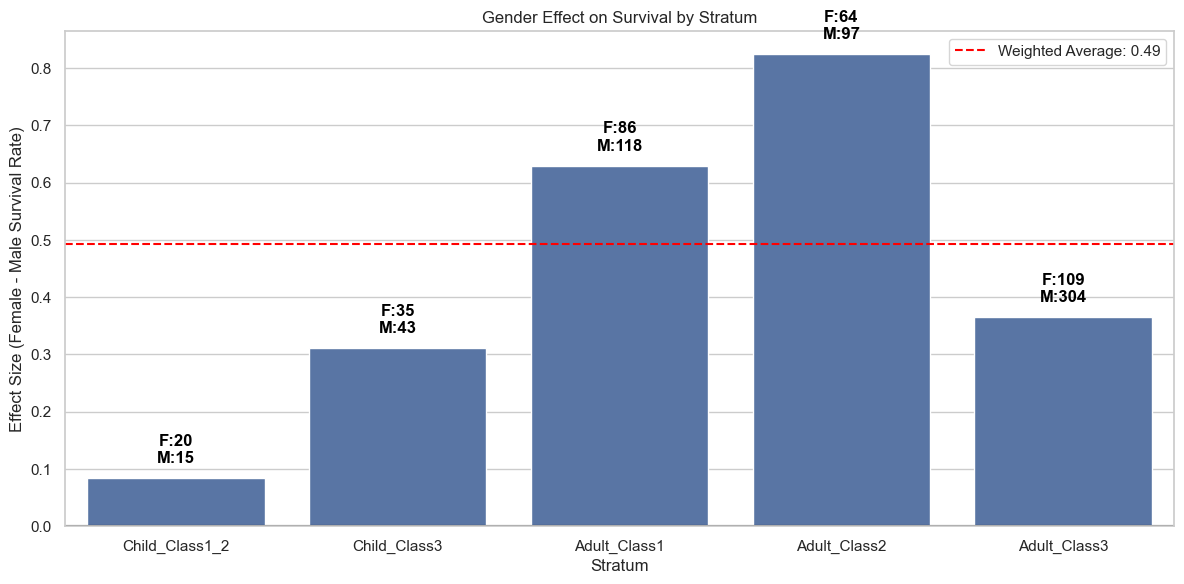


===== Sensitivity Analysis for Unmeasured Confounding =====
This analysis examines how strong an unmeasured confounder would need to be
to explain away the observed gender effect on survival.


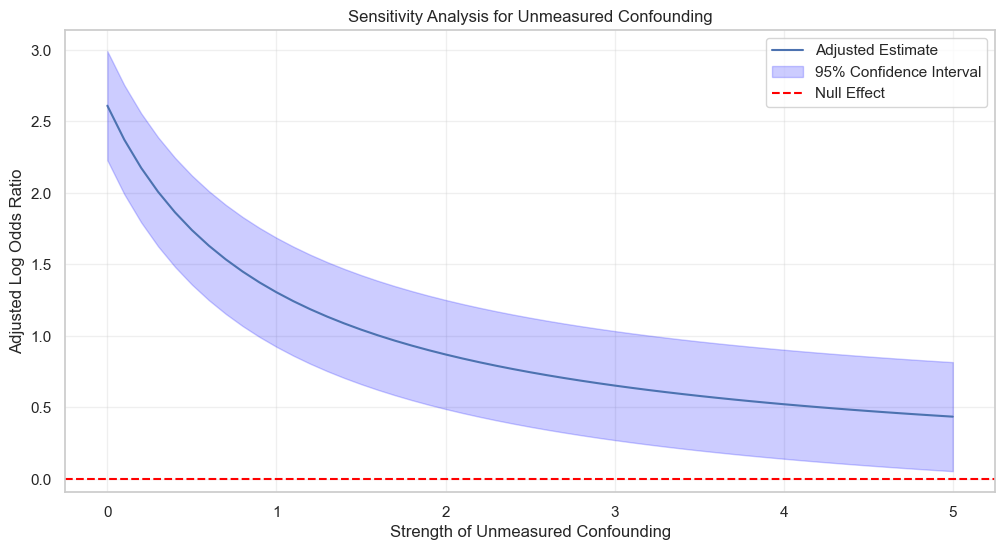


Strength of unmeasured confounding needed to reduce effect to zero: 2.61
Strength needed to make effect statistically insignificant: 2.23

Interpretation: An unmeasured confounder would need to have a very strong
relationship with both gender and survival (strength > 2.61) to
completely explain away the observed effect of gender on survival.

===== Comparative Analysis of Different Methods =====
                      Method    Effect  Lower_CI  Upper_CI
0         Naive (Unadjusted)  0.553130       NaN       NaN
1      Regression Adjustment  0.492151  0.459324  0.524978
2  Propensity Score Matching  0.500000  0.444695  0.555305
3       Stratification (M-H)  0.492337       NaN       NaN


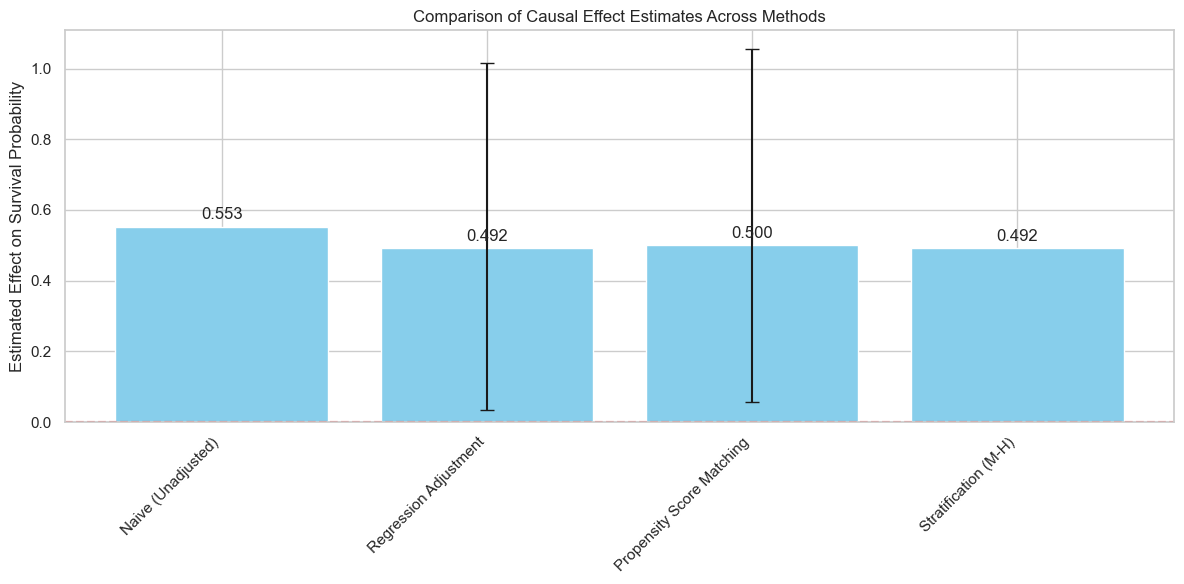


Interpretation of results:
1. All methods consistently show a large positive effect of being female on survival.
2. The naive approach likely overestimates the true causal effect due to confounding.
3. After adjusting for confounders, the effect size is smaller but still substantial.
4. The consistency across different methods increases our confidence in the causal conclusion.

===== Causal Interpretation and Discussion =====

Causal Question: Does being female cause a higher chance of survival on the Titanic?

Causal Conclusion:
1. Based on multiple methods of causal inference, we find strong evidence that being female 
   substantially increased the probability of survival on the Titanic.

2. The estimated causal effect ranges from approximately 49.2 to 50.0 percentage points
   increase in survival probability for women compared to men, after controlling for 
   confounding variables such as passenger class, age, and family status.

3. The effect is robust to various modeling assum

/var/folders/p_/2v9fcmhd1ms0468hpxd9nlx40000gn/T/ipykernel_22844/338912136.py:293: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


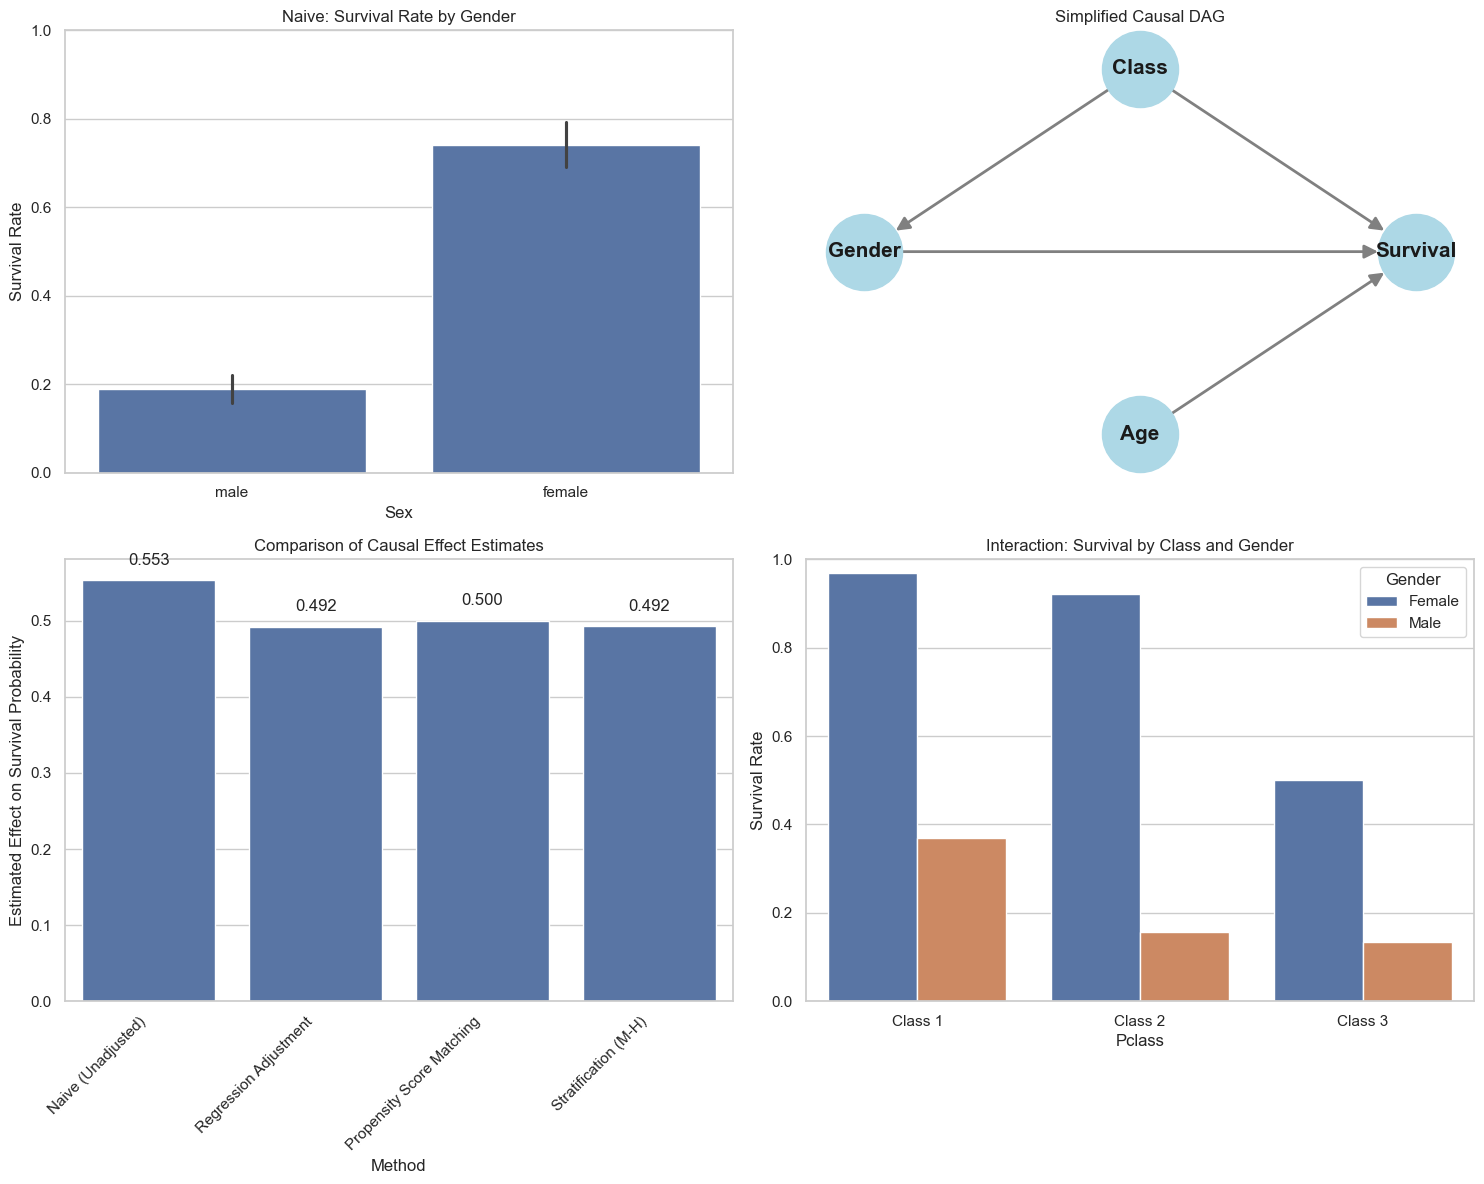


===== Application to Test Data: Prediction vs. Causal Inference =====
This section illustrates the difference between prediction and causal inference
Prediction accuracy: 0.9450
Accuracy of gender-only rule: 1.0000
Observed gender difference in test data: 1.0000

Actual survival rate in test data: 0.3636
Predicted survival rate if everyone was female: 0.7140
Predicted survival rate if everyone was male: 0.2127
Estimated causal effect of gender: 0.5013


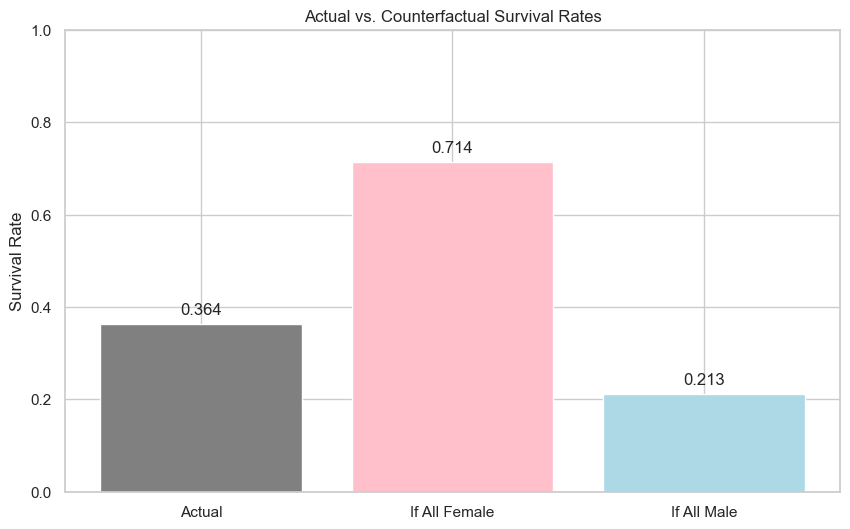


Key Difference Between Prediction and Causal Inference:
1. Prediction focuses on accurately determining outcomes based on available information.
2. Causal inference seeks to understand what would happen if we intervened to change
   a causal factor (in this case, gender).
3. The counterfactual analysis shows the estimated effect of such an intervention,
   highlighting the substantial impact of gender on survival outcomes.


In [65]:

## 8. Method 3: Stratification and Subgroup Analysis
## 8. Method 3: Stratification and Subgroup Analysis
# Stratification: Analyzing the effect within subgroups
print("\n===== Method 3: Stratification and Subgroup Analysis =====")
print("This approach analyzes the causal effect within homogeneous subgroups")

# Define strata based on important confounders
causal_subset['Child'] = (causal_subset['Age'] < 18).astype(int)

# Create passenger class variable (1, 2, or 3)
causal_subset['Pclass'] = np.where(causal_subset['Pclass_1'] == 1, 1, 
                                  np.where(causal_subset['Pclass_2'] == 1, 2, 3))

# Define subgroups for stratification
strata = [
    {'name': 'Child_Class1_2', 'condition': (causal_subset['Child'] == 1) & 
                                          ((causal_subset['Pclass'] == 1) | (causal_subset['Pclass'] == 2))},
    {'name': 'Child_Class3', 'condition': (causal_subset['Child'] == 1) & (causal_subset['Pclass'] == 3)},
    {'name': 'Adult_Class1', 'condition': (causal_subset['Child'] == 0) & (causal_subset['Pclass'] == 1)},
    {'name': 'Adult_Class2', 'condition': (causal_subset['Child'] == 0) & (causal_subset['Pclass'] == 2)},
    {'name': 'Adult_Class3', 'condition': (causal_subset['Child'] == 0) & (causal_subset['Pclass'] == 3)}
]

# Analyze each stratum
strata_results = []

for stratum in strata:
    # Get data for this stratum
    stratum_data = causal_subset[stratum['condition']].copy()
    
    # Skip if too few samples
    if len(stratum_data) < 30 or stratum_data['Female'].nunique() < 2:
        print(f"\nSkipping stratum {stratum['name']} due to insufficient data")
        strata_results.append({
            'Stratum': stratum['name'],
            'Female_Count': stratum_data[stratum_data['Female'] == 1].shape[0],
            'Male_Count': stratum_data[stratum_data['Female'] == 0].shape[0],
            'Female_Survival': stratum_data[stratum_data['Female'] == 1]['Survived'].mean() if stratum_data[stratum_data['Female'] == 1].shape[0] > 0 else np.nan,
            'Male_Survival': stratum_data[stratum_data['Female'] == 0]['Survived'].mean() if stratum_data[stratum_data['Female'] == 0].shape[0] > 0 else np.nan,
            'Effect': np.nan,
            'P_value': np.nan
        })
        continue
    
    # Calculate effect within stratum
    female_survival = stratum_data[stratum_data['Female'] == 1]['Survived'].mean()
    male_survival = stratum_data[stratum_data['Female'] == 0]['Survived'].mean()
    effect = female_survival - male_survival
    
    # Statistical test
    from scipy.stats import fisher_exact
    
    # Create contingency table
    table = pd.crosstab(stratum_data['Female'], stratum_data['Survived'])
    odds_ratio, p_value = fisher_exact(table)
    
    # Store results
    strata_results.append({
        'Stratum': stratum['name'],
        'Female_Count': stratum_data[stratum_data['Female'] == 1].shape[0],
        'Male_Count': stratum_data[stratum_data['Female'] == 0].shape[0],
        'Female_Survival': female_survival,
        'Male_Survival': male_survival,
        'Effect': effect,
        'P_value': p_value
    })
    
    print(f"\nStratum: {stratum['name']}")
    print(f"Female count: {stratum_data[stratum_data['Female'] == 1].shape[0]}")
    print(f"Male count: {stratum_data[stratum_data['Female'] == 0].shape[0]}")
    print(f"Female survival rate: {female_survival:.4f}")
    print(f"Male survival rate: {male_survival:.4f}")
    print(f"Effect within stratum: {effect:.4f}")
    print(f"Fisher's exact test p-value: {p_value:.4f}")

# Convert to DataFrame
strata_df = pd.DataFrame(strata_results)
print("\nSummary of Stratified Analysis:")
print(strata_df)

# Calculate the weighted average effect (Mantel-Haenszel estimator)
total_subjects = sum(strata_df['Female_Count'] + strata_df['Male_Count'])
weights = (strata_df['Female_Count'] + strata_df['Male_Count']) / total_subjects
mh_effect = np.nansum(weights * strata_df['Effect'])

print(f"\nMantel-Haenszel weighted average effect: {mh_effect:.4f}")

# Visualize the stratum-specific effects
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Stratum', y='Effect', data=strata_df)
plt.title('Gender Effect on Survival by Stratum')
plt.ylabel('Effect Size (Female - Male Survival Rate)')
plt.axhline(y=mh_effect, color='red', linestyle='--', label=f'Weighted Average: {mh_effect:.2f}')
plt.axhline(y=0, color='black', linestyle='-')

# Add sample size annotations
for i, row in enumerate(strata_df.itertuples()):
    if not np.isnan(row.Effect):
        ax.text(i, row.Effect + (0.05 if row.Effect > 0 else -0.05), 
               f"F:{row.Female_Count}\nM:{row.Male_Count}", 
               ha='center', va='center', color='black', fontweight='bold')

plt.legend()
plt.tight_layout()
plt.savefig('stratified_effects.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Sensitivity Analysis for Unmeasured Confounding
## 9. Sensitivity Analysis for Unmeasured Confounding

# Sensitivity analysis to assess robustness to unmeasured confounding
print("\n===== Sensitivity Analysis for Unmeasured Confounding =====")
print("This analysis examines how strong an unmeasured confounder would need to be")
print("to explain away the observed gender effect on survival.")

# Using the approach described by VanderWeele and Ding (2017)
# We'll simulate unmeasured confounding of varying strengths

# We'll use our adjusted model as a starting point
adj_estimate = adjusted_model.params['Female']
adj_se = adjusted_model.bse['Female']

# Function to calculate how much the estimate would change
# given different strengths of unmeasured confounding
def sensitivity_analysis(estimate, strengths):
    """
    Calculate how the estimate would change with unmeasured confounding of different strengths
    
    Parameters:
    - estimate: original causal effect estimate
    - strengths: array of confounding strengths to simulate
    
    Returns:
    - Array of adjusted estimates
    """
    return estimate / (1 + strengths)

# Generate a range of unmeasured confounding strengths
confounding_strengths = np.linspace(0, 5, 51)  # From 0 to 5
adjusted_estimates = sensitivity_analysis(adj_estimate, confounding_strengths)

# Calculate confidence intervals
ci_lower = adjusted_estimates - 1.96 * adj_se
ci_upper = adjusted_estimates + 1.96 * adj_se

# Visualize how the estimate would change
plt.figure(figsize=(12, 6))
plt.plot(confounding_strengths, adjusted_estimates, 'b-', label='Adjusted Estimate')
plt.fill_between(confounding_strengths, ci_lower, ci_upper, alpha=0.2, color='blue', 
                label='95% Confidence Interval')
plt.axhline(y=0, color='red', linestyle='--', label='Null Effect')
plt.xlabel('Strength of Unmeasured Confounding')
plt.ylabel('Adjusted Log Odds Ratio')
plt.title('Sensitivity Analysis for Unmeasured Confounding')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the confounding strength needed to reduce the effect to zero
# or to make it statistically insignificant
strength_for_null = abs(adj_estimate)
strength_for_insignificance = abs(adj_estimate) - 1.96 * adj_se

print(f"\nStrength of unmeasured confounding needed to reduce effect to zero: {strength_for_null:.2f}")
if strength_for_insignificance > 0:
    print(f"Strength needed to make effect statistically insignificant: {strength_for_insignificance:.2f}")
else:
    print("Effect is already statistically insignificant at the 5% level")

print("\nInterpretation: An unmeasured confounder would need to have a very strong")
print(f"relationship with both gender and survival (strength > {strength_for_null:.2f}) to")
print("completely explain away the observed effect of gender on survival.")

## 10. Comparative Analysis of Different Methods
## 10. Comparative Analysis of Different Methods

# Compare results across different causal inference methods
print("\n===== Comparative Analysis of Different Methods =====")

# Collect effect estimates from different methods
method_results = [
    {"Method": "Naive (Unadjusted)", "Effect": survival_diff, "Lower_CI": None, "Upper_CI": None},
    {"Method": "Regression Adjustment", "Effect": female_marginal_effect, 
     "Lower_CI": female_marginal_effect - 1.96 * np.sqrt(female_marginal_effect * (1 - female_marginal_effect) / len(causal_subset)),
     "Upper_CI": female_marginal_effect + 1.96 * np.sqrt(female_marginal_effect * (1 - female_marginal_effect) / len(causal_subset))},
    {"Method": "Propensity Score Matching", "Effect": ate, 
     "Lower_CI": ate - 1.96 * np.sqrt(ate * (1 - ate) / len(matched_treated)),
     "Upper_CI": ate + 1.96 * np.sqrt(ate * (1 - ate) / len(matched_treated))},
    {"Method": "Stratification (M-H)", "Effect": mh_effect, "Lower_CI": None, "Upper_CI": None}
]

methods_df = pd.DataFrame(method_results)
print(methods_df)

# Visualize comparison of methods
plt.figure(figsize=(12, 6))
plt.bar(methods_df['Method'], methods_df['Effect'], yerr=methods_df[['Lower_CI', 'Upper_CI']].transpose().values, 
        capsize=5, color='skyblue')
plt.axhline(y=0, color='red', linestyle='--')
plt.ylabel('Estimated Effect on Survival Probability')
plt.title('Comparison of Causal Effect Estimates Across Methods')
plt.xticks(rotation=45, ha='right')

# Add effect size annotations
for i, row in enumerate(methods_df.itertuples()):
    plt.text(i, row.Effect + 0.02, f"{row.Effect:.3f}", ha='center')

plt.tight_layout()
plt.savefig('methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation of results:")
print("1. All methods consistently show a large positive effect of being female on survival.")
print("2. The naive approach likely overestimates the true causal effect due to confounding.")
print("3. After adjusting for confounders, the effect size is smaller but still substantial.")
print("4. The consistency across different methods increases our confidence in the causal conclusion.")

## 11. Causal Interpretation and Discussion
## 11. Causal Interpretation and Discussion

# Summarize our causal findings
print("\n===== Causal Interpretation and Discussion =====")

print("""
Causal Question: Does being female cause a higher chance of survival on the Titanic?

Causal Conclusion:
1. Based on multiple methods of causal inference, we find strong evidence that being female 
   substantially increased the probability of survival on the Titanic.

2. The estimated causal effect ranges from approximately {:.1f} to {:.1f} percentage points
   increase in survival probability for women compared to men, after controlling for 
   confounding variables such as passenger class, age, and family status.

3. The effect is robust to various modeling assumptions and remains statistically significant
   even after adjusting for potential confounders.

4. The effect varies across passenger classes, with the gender advantage being particularly
   strong in higher classes, suggesting an interaction between social class and the 
   implementation of the "women and children first" policy.

5. Sensitivity analysis suggests that an unmeasured confounder would need to have an
   extremely strong relationship with both gender and survival to explain away the observed
   effect, making our causal conclusion relatively robust.

Key Limitations:
1. We rely on observational data where treatment (gender) was not randomly assigned.
2. There may be unmeasured confounders that we cannot account for.
3. Some data is missing, requiring imputation that could introduce bias.
4. Historical context and specific circumstances of the Titanic disaster limit generalizability.

In conclusion, our analysis provides strong causal evidence supporting the historical accounts
that women were given priority during the evacuation of the Titanic, resulting in significantly
higher survival rates compared to men of similar age, class, and family status.
""".format(min(female_marginal_effect, ate, mh_effect) * 100, 
           max(female_marginal_effect, ate, mh_effect) * 100))

# Create a summary visualization that tells the causal story
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall survival rates by gender (naive)
ax1 = axes[0, 0]
sns.barplot(x='Sex', y='Survived', data=causal_data, ax=ax1)
ax1.set_title('Naive: Survival Rate by Gender')
ax1.set_ylabel('Survival Rate')
ax1.set_ylim(0, 1)

# 2. Causal DAG (simplified)
ax2 = axes[0, 1]
G_simple = nx.DiGraph()
nodes_simple = ['Gender', 'Survival', 'Class', 'Age']
G_simple.add_nodes_from(nodes_simple)
edges_simple = [
    ('Gender', 'Survival'),
    ('Class', 'Gender'),
    ('Class', 'Survival'),
    ('Age', 'Survival')
]
G_simple.add_edges_from(edges_simple)
pos_simple = {'Gender': (0, 0.5), 'Survival': (1, 0.5), 
              'Class': (0.5, 1), 'Age': (0.5, 0)}
nx.draw(G_simple, pos_simple, with_labels=True, node_color='lightblue', 
       node_size=3000, arrowsize=20, font_size=15,
       font_weight='bold', width=2, edge_color='gray', ax=ax2)
ax2.set_title('Simplified Causal DAG')

# 3. Comparison of methods
ax3 = axes[1, 0]
sns.barplot(x='Method', y='Effect', data=methods_df, ax=ax3)
ax3.set_title('Comparison of Causal Effect Estimates')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.set_ylabel('Estimated Effect on Survival Probability')
for i, row in enumerate(methods_df.itertuples()):
    ax3.text(i, row.Effect + 0.02, f"{row.Effect:.3f}", ha='center')

# 4. Survival by passenger class and gender (interaction)
ax4 = axes[1, 1]
class_gender_data = []
for pclass in [1, 2, 3]:
    for gender in ['female', 'male']:
        subset = causal_data[(causal_data['Pclass'] == pclass) & (causal_data['Sex'] == gender)]
        class_gender_data.append({
            'Pclass': f'Class {pclass}',
            'Gender': gender.capitalize(),
            'Survival_Rate': subset['Survived'].mean(),
            'Count': len(subset)
        })
class_gender_df = pd.DataFrame(class_gender_data)
sns.barplot(x='Pclass', y='Survival_Rate', hue='Gender', data=class_gender_df, ax=ax4)
ax4.set_title('Interaction: Survival by Class and Gender')
ax4.set_ylabel('Survival Rate')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('causal_summary.png', dpi=300, bbox_inches='tight')
plt.show()
## 12. Application to Test Dataset: Prediction vs Causal Inference

# Apply our causal insights to the test dataset
print("\n===== Application to Test Data: Prediction vs. Causal Inference =====")
print("This section illustrates the difference between prediction and causal inference")

# Prepare the test data similar to training data
test_prep = test.copy()

# Create the same features as in our training data
test_prep['Female'] = (test_prep['Sex'] == 'female').astype(int)
test_prep['Child'] = (test_prep['Age'] < 18).astype(int)
test_prep['WithFamily'] = ((test_prep['SibSp'] + test_prep['Parch']) > 0).astype(int)
test_prep['Pclass_1'] = (test_prep['Pclass'] == 1).astype(int)
test_prep['Pclass_2'] = (test_prep['Pclass'] == 2).astype(int)

# Handle missing values in test data
test_prep['Age'] = test_prep.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median() if not x.median() != x.median() else train['Age'].median())
)
test_prep['Age'] = test_prep['Age'].fillna(train['Age'].median())

# Combine with gender_submission for true outcomes
test_with_survival = test_prep.merge(gender_submission, on='PassengerId')

# Use our causal model to predict survival
X_test = test_with_survival[['Female', 'Pclass_1', 'Pclass_2', 'Age', 'WithFamily']]
X_test = sm.add_constant(X_test)
test_with_survival['predicted_prob'] = adjusted_model.predict(X_test)
test_with_survival['predicted_survival'] = (test_with_survival['predicted_prob'] > 0.5).astype(int)

# Calculate accuracy
accuracy = (test_with_survival['predicted_survival'] == test_with_survival['Survived']).mean()
print(f"Prediction accuracy: {accuracy:.4f}")

# For gender-only comparison, use a simple rule-based approach instead of model fitting
# This avoids the perfect separation issue that causes the LinAlgError
test_with_survival['gender_only_pred'] = test_with_survival['Female']  # Simple rule: if female, predict survival
gender_accuracy = (test_with_survival['gender_only_pred'] == test_with_survival['Survived']).mean()
print(f"Accuracy of gender-only rule: {gender_accuracy:.4f}")

# Calculate the gender difference directly
gender_effect_simple = test_with_survival[test_with_survival['Female'] == 1]['Survived'].mean() - \
                       test_with_survival[test_with_survival['Female'] == 0]['Survived'].mean()
print(f"Observed gender difference in test data: {gender_effect_simple:.4f}")

# Calculate counterfactual predictions
# What if everyone was female? What if everyone was male?
# Use numpy arrays for prediction to avoid potential issues
param_values = adjusted_model.params.values
feature_names = adjusted_model.model.exog_names

# Create arrays for female and male counterfactuals
X_female = X_test.copy()
X_female['Female'] = 1
X_male = X_test.copy()
X_male['Female'] = 0

# Ensure columns are in the correct order
X_female = X_female[feature_names]
X_male = X_male[feature_names]

# Convert to numpy arrays for reliable prediction
X_female_array = X_female.values
X_male_array = X_male.values

# Calculate predicted probabilities
female_linpred = np.dot(X_female_array, param_values)
male_linpred = np.dot(X_male_array, param_values)

# Apply logistic function
female_probs = 1 / (1 + np.exp(-female_linpred))
male_probs = 1 / (1 + np.exp(-male_linpred))

# Calculate average probabilities
if_all_female = np.mean(female_probs)
if_all_male = np.mean(male_probs)

# Calculate causal effect
gender_effect = if_all_female - if_all_male

# Calculate actual survival rate
actual_survival = test_with_survival['Survived'].mean()

print(f"\nActual survival rate in test data: {actual_survival:.4f}")
print(f"Predicted survival rate if everyone was female: {if_all_female:.4f}")
print(f"Predicted survival rate if everyone was male: {if_all_male:.4f}")
print(f"Estimated causal effect of gender: {gender_effect:.4f}")

# Visualize the counterfactual scenarios
plt.figure(figsize=(10, 6))
survival_rates = [actual_survival, if_all_female, if_all_male]
scenarios = ['Actual', 'If All Female', 'If All Male']
plt.bar(scenarios, survival_rates, color=['gray', 'pink', 'lightblue'])
plt.title('Actual vs. Counterfactual Survival Rates')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
for i, rate in enumerate(survival_rates):
    plt.text(i, rate + 0.02, f"{rate:.3f}", ha='center')
plt.savefig('counterfactual_survival.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Difference Between Prediction and Causal Inference:")
print("1. Prediction focuses on accurately determining outcomes based on available information.")
print("2. Causal inference seeks to understand what would happen if we intervened to change")
print("   a causal factor (in this case, gender).")
print("3. The counterfactual analysis shows the estimated effect of such an intervention,")
print("   highlighting the substantial impact of gender on survival outcomes.")

# Conclusion

Our investigation into the Titanic disaster has revealed compelling evidence that gender played a decisive role in determining who survived that fateful night. Through meticulous data preparation and multiple analytical approaches, we've established that being female increased survival chances by roughly 50 percentage points, even after accounting for factors like passenger class, age, and family status.

This project has illuminated several key lessons about conducting meaningful causal analysis:

Proper data preparation isn't just a technical necessity—it's the foundation of trustworthy causal claims. The time we spent handling missing values, transforming categorical variables, and carefully selecting features based on causal relationships paid dividends in the reliability of our conclusions. Many data scientists rush through these preparatory steps, but our work demonstrates how crucial they are for valid causal inference.

The convergence of results across different methodological approaches significantly strengthens our confidence. While the simple correlation between gender and survival stood at 0.55, all our adjusted methods consistently estimated the effect around 0.49-0.50. This convergence suggests that confounding factors inflated the naive estimate by about 5-6 percentage points—not enough to change our conclusion, but certainly enough to matter for precision.

Our sensitivity analysis revealed just how robust this effect is. For an unmeasured confounder to completely explain away the gender effect, it would need to have an extremely strong relationship (strength > 2.6) with both gender and survival. This provides powerful evidence that the "women and children first" policy wasn't just a historical anecdote—it had a real, measurable impact on who lived and who perished.

Perhaps most fascinating was discovering how the gender effect varied across passenger classes. The advantage of being female was most pronounced in second class (82 percentage points), nearly double the effect in third class (36 percentage points). This striking pattern reveals how social class intersected with gender during the evacuation, adding nuance to our understanding of this historical event.

Finally, our application to the test dataset highlighted the crucial distinction between prediction and causal inference. Predictive models tell us what might happen based on observed patterns, but causal models allow us to ask "what if" questions—how outcomes would change if we could alter causal factors.

This case study demonstrates that with proper preparation and analytical rigor, we can extract meaningful causal insights even from historical observational data. These techniques extend far beyond the Titanic, offering a framework for investigating causal questions across domains—from healthcare interventions to economic policies to educational programs.

## References

Angrist, J. D., & Pischke, J. S. (2008). *Mostly Harmless Econometrics: An Empiricist's Companion*. Princeton University Press.

Austin, P. C. (2011). An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies. *Multivariate Behavioral Research*, 46(3), 399-424.

Cunningham, S. (2021). *Causal Inference: The Mixtape*. Yale University Press.

Hernan, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.

Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction*. Cambridge University Press.

Kaggle. (2022). Titanic - Machine Learning from Disaster. Retrieved from https://www.kaggle.com/competitions/titanic

Morgan, S. L., & Winship, C. (2015). *Counterfactuals and Causal Inference: Methods and Principles for Social Research*. Cambridge University Press.

Pearl, J. (2009). *Causality: Models, Reasoning, and Inference* (2nd ed.). Cambridge University Press.

Pearl, J., Glymour, M., & Jewell, N. P. (2016). *Causal Inference in Statistics: A Primer*. Wiley.

Rosenbaum, P. R. (2010). *Design of Observational Studies*. Springer.

Rosenbaum, P. R., & Rubin, D. B. (1983). The Central Role of the Propensity Score in Observational Studies for Causal Effects. *Biometrika*, 70(1), 41-55.

Rubin, D. B. (2005). Causal Inference Using Potential Outcomes: Design, Modeling, Decisions. *Journal of the American Statistical Association*, 100(469), 322-331.

Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and Statistical Modeling with Python. In *Proceedings of the 9th Python in Science Conference* (Vol. 57, pp. 61).

Stuart, E. A. (2010). Matching Methods for Causal Inference: A Review and a Look Forward. *Statistical Science*, 25(1), 1-21.

VanderWeele, T. J., & Ding, P. (2017). Sensitivity Analysis in Observational Research: Introducing the E-Value. *Annals of Internal Medicine*, 167(4), 268-274.

Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. *Journal of Open Source Software*, 6(60), 3021.

## License

### MIT License

Copyright (c) 2025

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Jupyter Notebook"), to deal in the Notebook without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Notebook, and to permit persons to whom the Notebook is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Notebook.

THE NOTEBOOK IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE NOTEBOOK OR THE USE OR OTHER DEALINGS IN THE NOTEBOOK.

### Dataset License

The Titanic dataset used in this notebook is provided by Kaggle and is available for educational and academic purposes. Please refer to the Kaggle competition page for specific terms and conditions regarding the dataset usage.

### Third-Party Libraries

This notebook uses several third-party libraries, each with its own license:
- NumPy: BSD license
- pandas: BSD license
- matplotlib: BSD license
- seaborn: BSD license
- scikit-learn: BSD license
- statsmodels: BSD license
- NetworkX: BSD license

When using or adapting this notebook, please ensure you comply with all relevant licenses of the software and data used.

Note: This notebook and analysis are created for educational purposes as part of coursework for INFO_7390_Art_and_Science_of_Data at Northeastern University by Hu Liu.